In [1]:
# import modules

import sys
print(sys.version)

import os

mingw_path = 'C:\\Program Files\\Git\\mingw64\\bin'
graphviz_path = 'C:\\Inicio\\tools\\64\\Anaconda3-5.2.0.1\\Library\\bin\\graphviz'

os.environ['PATH'] = mingw_path + ';' + graphviz_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [2]:
# Load test and train set
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
# Sorting data for item and store
single_train = train_df.copy()
store_ids = [8,8]
print(store_ids)
item_ids = [5, 15, 25, 35, 45]
print("Before filter:", single_train.shape)
single_train = single_train[single_train.store.isin(store_ids)]
single_train = single_train[single_train.item.isin(item_ids)]
print("After filter:", single_train.shape)

# Plotting
ts_data = []
for st,it in zip(store_ids, item_ids):
    flt = single_train[single_train.store == st]
    flt = flt[flt.item == it]
    ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name= "Store:" + str(st) + ",Item:" + str(it)))
py.iplot(ts_data)

[8, 8]
Before filter: (913000, 4)
After filter: (9130, 4)


In [4]:
# retain only item 15 in store 8 & reset index
item15_store8 = train_df.copy()
item15_store8 = item15_store8.loc[(item15_store8['store'] == 8) & (item15_store8['item'] ==15)]
item15_store8 = item15_store8.reset_index(drop=True)

pre_train_0815 = item15_store8.copy()
#display(item15_store8)

In [5]:
pre_train_0815.sales.describe()

count    1826.000000
mean      108.047645
std        28.265443
min        39.000000
25%        87.000000
50%       107.000000
75%       127.000000
max       200.000000
Name: sales, dtype: float64

In [6]:
#
# Feature engineering part 1 - create datetime values
#
pre_train_0815['date']=pd.to_datetime(pre_train_0815['date'])
pre_train_0815['year'] = pre_train_0815['date'].dt.year
pre_train_0815['quarter'] = pre_train_0815['date'].dt.quarter
pre_train_0815['month'] = pre_train_0815['date'].dt.month
pre_train_0815['weekofyear'] = pre_train_0815['date'].dt.weekofyear
pre_train_0815['weekday'] = pre_train_0815['date'].dt.weekday


#
# Feature engineering part 2 - create rolling means (important for time series)
#

# Total rolling mean
pre_train_0815['total_rolling_mean'] = pre_train_0815['sales']
for i in range(len(pre_train_0815)):
    pre_train_0815.loc[i, 'total_rolling_mean'] = pre_train_0815['sales'].iloc[:i+1].mean()
    
pre_train_0815['total_rolling_mean_lag'] = pre_train_0815['sales']
for i in range(len(pre_train_0815)):
    pre_train_0815.loc[i, 'total_rolling_mean_lag'] = pre_train_0815['sales'].iloc[:i].mean()
    
# Year rolling mean
pre_train_0815['year_rolling_mean'] = pre_train_0815['sales']
sum_iter = 0
for years in pre_train_0815.year.unique():
    for j in range(len(pre_train_0815[pre_train_0815['year'] == years])):
        pre_train_0815.loc[sum_iter+j,'year_rolling_mean'] = pre_train_0815[pre_train_0815['year'] == years]['sales'].iloc[:j+1].mean()
    sum_iter += len(pre_train_0815[pre_train_0815['year'] == years]) 
# Lag 
pre_train_0815['year_rolling_mean_lag'] = pre_train_0815['sales']
for years in pre_train_0815.year.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['year'] == years].index):
        pre_train_0815.loc[idx,'year_rolling_mean_lag'] = pre_train_0815[pre_train_0815['year'] == years]['sales'].iloc[:j].mean()     
    
# Quarter rolling mean
pre_train_0815['quarter_rolling_mean'] = pre_train_0815['sales']
for quarters in pre_train_0815.quarter.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['quarter'] == quarters].index):
        pre_train_0815.loc[idx,'quarter_rolling_mean'] = pre_train_0815[pre_train_0815['quarter'] == quarters]['sales'].iloc[:j+1].mean()     
# Lag
pre_train_0815['quarter_rolling_mean_lag'] = pre_train_0815['sales']
for quarters in pre_train_0815.quarter.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['quarter'] == quarters].index):
        pre_train_0815.loc[idx,'quarter_rolling_mean_lag'] = pre_train_0815[pre_train_0815['quarter'] == quarters]['sales'].iloc[:j].mean() 
        
# Month rolling mean
pre_train_0815['month_rolling_mean'] = pre_train_0815['sales']
for months in pre_train_0815.month.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['month'] == months].index):
        pre_train_0815.loc[idx,'month_rolling_mean'] = pre_train_0815[pre_train_0815['month'] == months]['sales'].iloc[:j+1].mean() 
# Lag
pre_train_0815['month_rolling_mean_lag'] = pre_train_0815['sales']
for months in pre_train_0815.month.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['month'] == months].index):
        pre_train_0815.loc[idx,'month_rolling_mean_lag'] = pre_train_0815[pre_train_0815['month'] == months]['sales'].iloc[:j].mean()  

# Week rolling mean
pre_train_0815['week_rolling_mean'] = pre_train_0815['sales']
for weeks in pre_train_0815.weekofyear.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['weekofyear'] == weeks].index):
        pre_train_0815.loc[idx,'week_rolling_mean'] = pre_train_0815[pre_train_0815['weekofyear'] == weeks]['sales'].iloc[:j+1].mean()         
# Lag
pre_train_0815['week_rolling_mean_lag'] = pre_train_0815['sales']
for weeks in pre_train_0815.weekofyear.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['weekofyear'] == weeks].index):
        pre_train_0815.loc[idx,'week_rolling_mean_lag'] = pre_train_0815[pre_train_0815['weekofyear'] == weeks]['sales'].iloc[:j].mean() 

# Day rolling mean
pre_train_0815['day_rolling_mean'] = pre_train_0815['sales']
for days in pre_train_0815.weekday.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['weekday'] == days].index):
        pre_train_0815.loc[idx,'day_rolling_mean'] = pre_train_0815[pre_train_0815['weekday'] == days]['sales'].iloc[:j+1].mean()         
# Lag
pre_train_0815['day_rolling_mean_lag'] = pre_train_0815['sales']
for days in pre_train_0815.weekday.unique():
    for j, idx in enumerate(pre_train_0815[pre_train_0815['weekday'] == days].index):
        pre_train_0815.loc[idx,'day_rolling_mean_lag'] = pre_train_0815[pre_train_0815['weekday'] == days]['sales'].iloc[:j].mean() 
        
        
pre_train_0815['year_mean'] = pre_train_0815.groupby(['year'])['sales'].transform('mean')
pre_train_0815['month_mean'] = pre_train_0815.groupby(['month'])['sales'].transform('mean')
pre_train_0815['quarter_mean'] = pre_train_0815.groupby(['quarter'])['sales'].transform('mean')
pre_train_0815['week_mean'] = pre_train_0815.groupby(['weekofyear'])['sales'].transform('mean')
pre_train_0815['day_mean'] = pre_train_0815.groupby(['weekday'])['sales'].transform('mean')
#display(pre_train_0815)

In [7]:
# Feature engineering part 3 - Create lagged actuals variables

pre_train_0815['lagged_1'] = pre_train_0815['sales'].shift(1)
pre_train_0815['lagged_2'] = pre_train_0815['sales'].shift(2)
pre_train_0815['lagged_3'] = pre_train_0815['sales'].shift(3)
pre_train_0815['lagged_4'] = pre_train_0815['sales'].shift(4)
pre_train_0815['lagged_5'] = pre_train_0815['sales'].shift(5)
pre_train_0815['lagged_6'] = pre_train_0815['sales'].shift(6)
pre_train_0815['lagged_7'] = pre_train_0815['sales'].shift(7)
pre_train_0815['lagged_month'] = pre_train_0815['sales'].shift(28)
pre_train_0815['lagged_year'] = pre_train_0815['sales'].shift(52*7) #364

display(pre_train_0815)

date  store  item  sales  year  quarter  month  weekofyear  \
0    2013-01-01      8    15     44  2013        1      1           1   
1    2013-01-02      8    15     56  2013        1      1           1   
2    2013-01-03      8    15     59  2013        1      1           1   
3    2013-01-04      8    15     66  2013        1      1           1   
4    2013-01-05      8    15     83  2013        1      1           1   
5    2013-01-06      8    15     71  2013        1      1           1   
6    2013-01-07      8    15     49  2013        1      1           2   
7    2013-01-08      8    15     74  2013        1      1           2   
8    2013-01-09      8    15     50  2013        1      1           2   
9    2013-01-10      8    15     46  2013        1      1           2   
10   2013-01-11      8    15     74  2013        1      1           2   
11   2013-01-12      8    15     58  2013        1      1           2   
12   2013-01-13      8    15     70  2013        1      1           2   
13   2013-01-14      8    15     56  2013        1      1           3   
14   2013-01-15      8    15     66  2013        1      1           3   
15   2013-01-16      8    15     61  2013        1      1           3   
16   2013-01-17      8    15     58  2013        1      1           3   
17   2013-01-18      8    15     67  2013        1      1           3   
18   2013-01-19      8    15     73  2013        1      1           3   
19   2013-01-20      8    15     79  2013        1      1           3   
20   2013-01-21      8    15     39  2013        1      1           4   
21   2013-01-22      8    15     53  2013        1      1           4   
22   2013-01-23      8    15     52  2013        1      1           4   
23   2013-01-24      8    15     54  2013        1      1           4   
24   2013-01-25      8    15     65  2013        1      1           4   
25   2013-01-26      8    15     64  2013        1      1           4   
26   2013-01-27      8    15     82  2013        1      1           4   
27   2013-01-28      8    15     60  2013        1      1           5   
28   2013-01-29      8    15     56  2013        1      1           5   
29   2013-01-30      8    15     61  2013        1      1           5   
...         ...    ...   ...    ...   ...      ...    ...         ...   
1796 2017-12-02      8    15    105  2017        4     12          48   
1797 2017-12-03      8    15    119  2017        4     12          48   
1798 2017-12-04      8    15    102  2017        4     12          49   
1799 2017-12-05      8    15     71  2017        4     12          49   
1800 2017-12-06      8    15     76  2017        4     12          49   
1801 2017-12-07      8    15    101  2017        4     12          49   
1802 2017-12-08      8    15     93  2017        4     12          49   
1803 2017-12-09      8    15    123  2017        4     12          49   
1804 2017-12-10      8    15    106  2017        4     12          49   
1805 2017-12-11      8    15     69  2017        4     12          50   
1806 2017-12-12      8    15     76  2017        4     12          50   
1807 2017-12-13      8    15     89  2017        4     12          50   
1808 2017-12-14      8    15     87  2017        4     12          50   
1809 2017-12-15      8    15     89  2017        4     12          50   
1810 2017-12-16      8    15     98  2017        4     12          50   
1811 2017-12-17      8    15     92  2017        4     12          50   
1812 2017-12-18      8    15     73  2017        4     12          51   
1813 2017-12-19      8    15     96  2017        4     12          51   
1814 2017-12-20      8    15     76  2017        4     12          51   
1815 2017-12-21      8    15    103  2017        4     12          51   
1816 2017-12-22      8    15     91  2017        4     12          51   
1817 2017-12-23      8    15     91  2017        4     12          51   
1818 2017-12-24      8    15    102  2017        4     12          51

In [8]:
# return frequency of days with max sales value per week
def freq_days():
    for i in range(pre_train_0815['year'].min(), pre_train_0815['year'].max()+1):
        print('year =%d' %i)
        count_mon = 0
        count_tue = 0
        count_wed = 0
        count_thu = 0
        count_fri = 0
        count_sat = 0
        count_sun = 0
        for j in range(1,pre_train_0815['weekofyear'].max()+1):
            print('week =%d' %j)
            day = pre_train_0815.loc[(pre_train_0815['year'] == i) & (pre_train_0815['weekofyear'] == j)].sales
            if day.empty:
                print('empty')
            elif pre_train_0815.loc[day.idxmax(), 'weekday'] == 1:
                count_mon += 1
            elif pre_train_0815.loc[day.idxmax(), 'weekday'] == 2:
                count_tue += 1
            elif pre_train_0815.loc[day.idxmax(), 'weekday'] == 3:
                count_wed += 1
            elif pre_train_0815.loc[day.idxmax(), 'weekday'] == 4:
                count_thu += 1
            elif pre_train_0815.loc[day.idxmax(), 'weekday'] == 5:
                count_fri += 1
            elif pre_train_0815.loc[day.idxmax(), 'weekday'] == 6:
                count_sat += 1
            elif pre_train_0815.loc[day.idxmax(), 'weekday'] == 7:
                count_sun += 1
        #print(pre_train_0815.loc[pre_train_0815['dayofweek'], day.argmax])
    print('year %d summary:\n monday:%d\n tuesday:%d\n wednesday:%d\n thursday:%d\n friday:%d\n saturday:%d\n sunday:%d'
          %(i,count_mon, count_tue, count_wed, count_thu, count_fri, count_sat, count_sun))
    count_mon = 0
    count_tue = 0
    count_wed = 0
    count_thu = 0
    count_fri = 0
    count_sat = 0
    count_sun = 0

#freq_days()
        

In [9]:
# train and test (holdout) set 
train_0815_ = pre_train_0815.copy()

train_0815 = train_0815_.iloc[:int(4/5*len(item15_store8)),:]
test_0815 = train_0815_.iloc[int(4/5*len(item15_store8)):,:] #holdout set
y_train_0815 = train_0815.sales
y_test_0815 = test_0815.sales
#display(test_0815)

In [10]:
# feature dropping (for all features - one hot encoded)
df_reduced = train_0815.copy()
df_reduced = df_reduced[['total_rolling_mean_lag', 'year_rolling_mean_lag', 'quarter_rolling_mean_lag', 'month_rolling_mean_lag', 'week_rolling_mean_lag', 'day_rolling_mean_lag', 'lagged_1', 'lagged_2', 'lagged_3', 'lagged_4', 'lagged_5', 'lagged_6', 'lagged_7', 'lagged_month', 'lagged_year']]

test_df_reduced = test_0815.copy()
test_df_reduced = test_df_reduced[['total_rolling_mean_lag', 'year_rolling_mean_lag', 'quarter_rolling_mean_lag', 'month_rolling_mean_lag', 'week_rolling_mean_lag', 'day_rolling_mean_lag', 'lagged_1', 'lagged_2', 'lagged_3', 'lagged_4', 'lagged_5', 'lagged_6', 'lagged_7', 'lagged_month', 'lagged_year']]

total_df_reduced = pre_train_0815.copy()
total_df_reduced = total_df_reduced[['total_rolling_mean_lag', 'year_rolling_mean_lag', 'quarter_rolling_mean_lag', 'month_rolling_mean_lag', 'week_rolling_mean_lag', 'day_rolling_mean_lag', 'lagged_1', 'lagged_2', 'lagged_3', 'lagged_4', 'lagged_5', 'lagged_6', 'lagged_7', 'lagged_month', 'lagged_year']]


# save the reduced version including all created features
pre_train_all_features = df_reduced.copy()
pre_train_all_features.to_csv('./data/pre_train_all_features.csv')

In [11]:
# Definition of SMAPE and MAPE metric
from numba import jit
import math

# SMAPE metric
@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

# MAPE metric
@jit
def mape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (100.0 / y_true.shape[0])
    return out

In [12]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [13]:
# functions to split the data

def time_series_split_chunk(df, num):
    cv_split_set = []
    tscv = TimeSeriesSplit(n_splits=num)
    for train_index, test_index in tscv.split(df):
        cv_split_set.append([train_index, test_index])
    return cv_split_set

def time_series_split_end(df, num):
    result = []
    for i in range(num):
        result.append([df.index[:-num+i].values, df.index[-num+i:].values])
    return result


def time_series_split_mod(df, num, mod):
    result = []
    for i in range(num):
        result.append([df.index[:int(-num*mod)+int(i*mod)].values, df.index[int(-num*mod)+int(i*mod):len(df_reduced)-int(num*mod)+int((i+1)*mod)].values])
    return result

def time_series_split_single(df, num):
    result = []
    for i in range(num):
        result.append([df.index[:-num+i], np.asarray(df.index[-num+i]).reshape(1,-1)])
    return result

split_test_chunk = time_series_split_chunk(df_reduced, 50)
    
split_test = time_series_split_end(df_reduced, 300)   
    
split_test_mod = time_series_split_mod(df_reduced, 30, 10) 

split_test_single = time_series_split_single(df_reduced, 300) 

In [17]:
# time series cross-validation

def model_test(data, labels, data_test, labels_test, split_func, num, mod=0):
    if not mod:
        cv_split_data = split_func(data,num)
    else:
        cv_split_data = split_func(data,num,mod)
           
    avg_mae = 0
    min_mae = float("Inf")
    avg_mape = 0
    min_mape = float("Inf")
    for i in range(0,len(cv_split_data)):
        if len(cv_split_data[i][1]) > 1:
            print("TRAIN-START:", cv_split_data[i][0][0], "-", cv_split_data[i][0][-1], " TEST-START:", cv_split_data[i][1][0], "-", cv_split_data[i][1][-1])
            X_train, X_test = data.values[cv_split_data[i][0]], data.values[cv_split_data[i][1]]
            y_train, y_test = labels.values[cv_split_data[i][0]], labels.values[cv_split_data[i][1]]
        else:
            print("TRAIN-START:", cv_split_data[i][0][0], "-", cv_split_data[i][0][-1], " TEST-START:", cv_split_data[i][1], "-", cv_split_data[i][1])
            X_train, X_test = df_reduced.values[cv_split_data[i][0]], df_reduced.values[cv_split_data[i][1]].reshape(1,-1)
            y_train, y_test = y_train_0815.values[cv_split_data[i][0]], np.asarray(y_train_0815.values[cv_split_data[i][1]]).reshape(1,-1)

        # Training of xgb model
        xgbtrain_ts = xgb.DMatrix(X_train, label=y_train)
        xgbvalidate_ts = xgb.DMatrix(X_test, label=y_test)
        xgbmodel_ts = xgb.train(list(params.items()), xgbtrain_ts, early_stopping_rounds=50, evals=[(xgbtrain_ts, 'train'), (xgbvalidate_ts, 'validate')], num_boost_round=900, verbose_eval=50)
        #xgb.plot_importance(xgbmodel_ts, max_num_features = 20)
        #print((xgbmodel_ts.attributes()))
        avg_mae = avg_mae + xgbmodel_ts.best_score
        pred = xgbmodel_ts.predict(xgb.DMatrix(data_test.values))
        mape_test = mape_fast(pred, labels_test.values)
        avg_mape = avg_mape + mape_test
        print("MAPE total (Round %d):%f" %(i, mape_test))
        if xgbmodel_ts.best_score < min_mae:
            min_mae = xgbmodel_ts.best_score
            best_mae_iter = i
        if mape_test < min_mape:
            min_mape = mape_test
            best_mape_iter = i

    print("Avg MAE:%f; Avg MAPE:%f\nBest MAE: iteration%d; Best MAPE: iteration%d" %(avg_mae/len(cv_split_data), avg_mape/len(cv_split_data), best_mae_iter, best_mape_iter))

In [18]:
# tuned parameters
params = {
    'colsample_bytree': 0.9,
    'eta': 0.1,
    'eval_metric': 'mae',
    'lambda': 1,
    'max_depth': 3,
    'min_child_weight': 6,
    'objective': 'reg:linear',
    'seed': 0,
    'silent': 1,
    'subsample': 0.9,
}

In [19]:
#model_test(df_reduced, y_train_0815, test_df_reduced, y_test_0815, time_series_split_mod, 30, 10)

In [20]:
#model_test(df_reduced, y_train_0815, test_df_reduced, y_test_0815, time_series_split_chunk, 50)

In [21]:
#model_test(df_reduced, y_train_0815, test_df_reduced, y_test_0815, time_series_split_end, 300)

In [297]:
#model_test(df_reduced, y_train_0815, test_df_reduced, y_test_0815, time_series_split_single, 300)

In [20]:
# final training

cv_split_final = [([range(1459)],[1459])]
cv_split_data = cv_split_final
%time
params = {
    'colsample_bytree': 0.9,
    'eta': 0.1,
    'eval_metric': 'mae',
    'lambda': 1,
    'max_depth': 3,
    'min_child_weight': 6,
    'objective': 'reg:linear',
    'seed': 0,
    'silent': 1,
    'subsample': 0.9,
}

avg_mae = 0
avg_mape = 0
for i in range(0,len(cv_split_data)):
    print("TRAIN-START:", cv_split_data[i][0][0], "-", cv_split_data[i][0][-1], " TEST-START:", cv_split_data[i][1][0], "-", cv_split_data[i][1][-1])
    X_train, X_test = df_reduced.values[cv_split_data[i][0]], df_reduced.values[cv_split_data[i][1]]
    y_train, y_test = y_train_0815.values[cv_split_data[i][0]], y_train_0815.values[cv_split_data[i][1]]
    # Training of xgb model
    print("Round")
    xgbtrain_ts = xgb.DMatrix(X_train, label=y_train)
    xgbvalidate_ts = xgb.DMatrix(X_test, label=y_test)
    xgbmodel_ts = xgb.train(list(params.items()), xgbtrain_ts, early_stopping_rounds=50, evals=[(xgbtrain_ts, 'train'), (xgbvalidate_ts, 'test')], num_boost_round=400, verbose_eval=50)
    #xgb.plot_importance(xgbmodel_ts, max_num_features = 20)
    #print((xgbmodel_ts.attributes()))
    avg_mae = avg_mae + xgbmodel_ts.best_score
    pred = xgbmodel_ts.predict(xgb.DMatrix(test_df_reduced.values))
    mape_test = mape_fast(y_test_0815.values, pred)
    avg_mape = avg_mape + mape_test
    print("MAPE total:%f" %mape_test)
    
print("Avg MAE:%f; Avg MAPE:%f" %(avg_mae/len(cv_split_data), avg_mape/len(cv_split_data)))

Wall time: 0 ns
TRAIN-START: range(0, 1459) - range(0, 1459)  TEST-START: 1459 - 1459
Round
[0]	train-mae:93.7788	test-mae:81.4416
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
[50]	train-mae:7.93168	test-mae:2.26659
Stopping. Best iteration:
[30]	train-mae:8.9151	test-mae:0.06324

MAPE total:8.777891
Avg MAE:0.063240; Avg MAPE:8.777891


In [21]:
model_0815 = xgbmodel_ts

# predict = predict2 of test (holdout); predict = without extra parameters (also used by SHAP later)

predict = model_0815.predict(xgb.DMatrix(test_df_reduced.values))
predict2=pd.DataFrame(model_0815.predict(xgb.DMatrix(test_df_reduced.values),ntree_limit=model_0815.best_ntree_limit))

In [24]:
# Prediction
%time
model_0815 = xgbmodel_ts

# predict = predict2 of test (holdout); predict = without extra parameters (also used by SHAP later)
predict = model_0815.predict(xgb.DMatrix(test_df_reduced.values))
predict2=pd.DataFrame(model_0815.predict(xgb.DMatrix(test_df_reduced.values),ntree_limit=model_0815.best_ntree_limit))


# predict_train2 = predict of train set; predict_train = without extra parameters (also used by SHAP later) 
predict_train = model_0815.predict(xgb.DMatrix(df_reduced.values))
predict_train2=pd.DataFrame(model_0815.predict(xgb.DMatrix(df_reduced.values),ntree_limit=model_0815.best_ntree_limit))



Wall time: 0 ns


In [25]:
import pickle
pickle.dump( predict_train, open( "predict_train.p", "wb" ) )
pickle.dump( df_reduced, open( "df_reduced.p", "wb" ) )

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



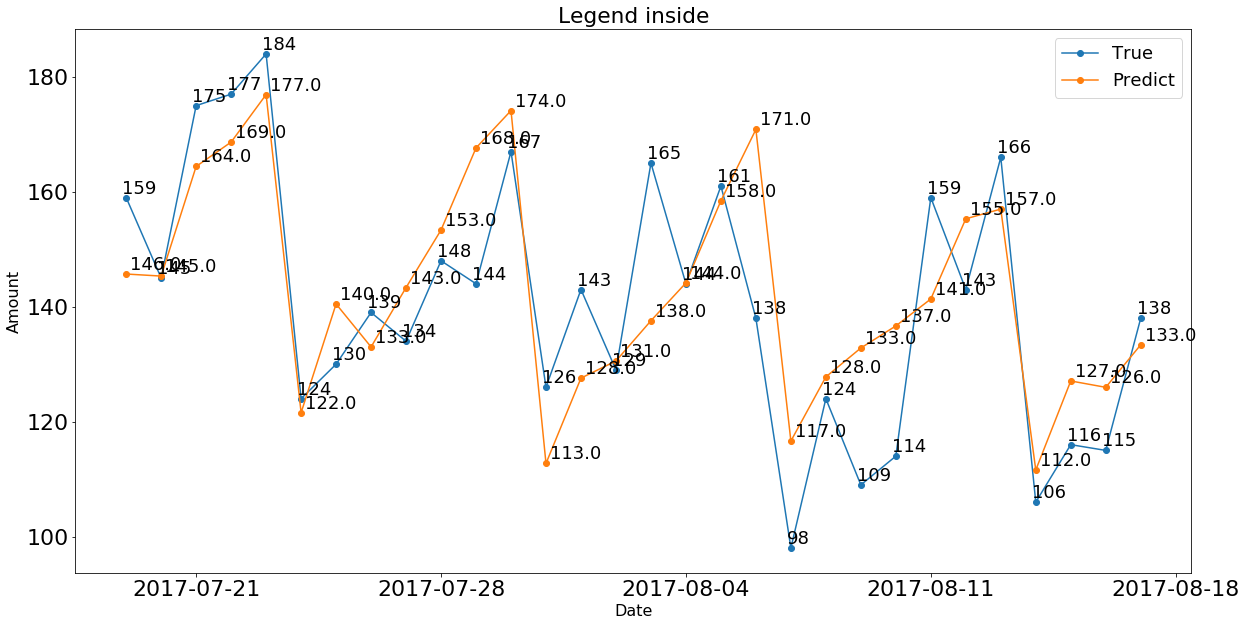

In [27]:
# Show excerpt of test actuals vs prediction
len_show = 30
start_show = 200

def plot_partial_graph(data, pred, start, length):
    fig = plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18})
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Amount', fontsize=16)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    ax.plot(data.date[start:start+length], data['sales'][start:start+length], label='True', marker = 'o')
    ax.plot(data.date[start:start+length], pred[start:start+length], label='Predict', marker = 'o')
    for x, y in zip(data.date[start:start+length], data['sales'][start:start+length]):                                       # <--
        ax.annotate('%s' % y, xy=(x,y), xytext = (-4,4), textcoords='offset points') # <--
    for x, y in zip(data.date[start:start+length], pred[start:start+length]):                                       # <--
        ax.annotate('%s' % round(y), xy=(x,y), xytext = (4,4), textcoords='offset points') # <--
    plt.title('Legend inside')
    ax.legend()
    plt.show()

plot_partial_graph(test_0815, predict, start_show, len_show)


Iteration: 44
Part: 0; MAPE: 9.247920;     Naive: 17.603733; MA: 12.568910
Part: 1; MAPE: 9.260270;     Naive: 15.359102; MA: 16.133791
Part: 2; MAPE: 9.024282;     Naive: 18.515173; MA: 16.980683
*************Total MAPE: 9.177491***************; Naive: 17.159336; MA: 15.227795


C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



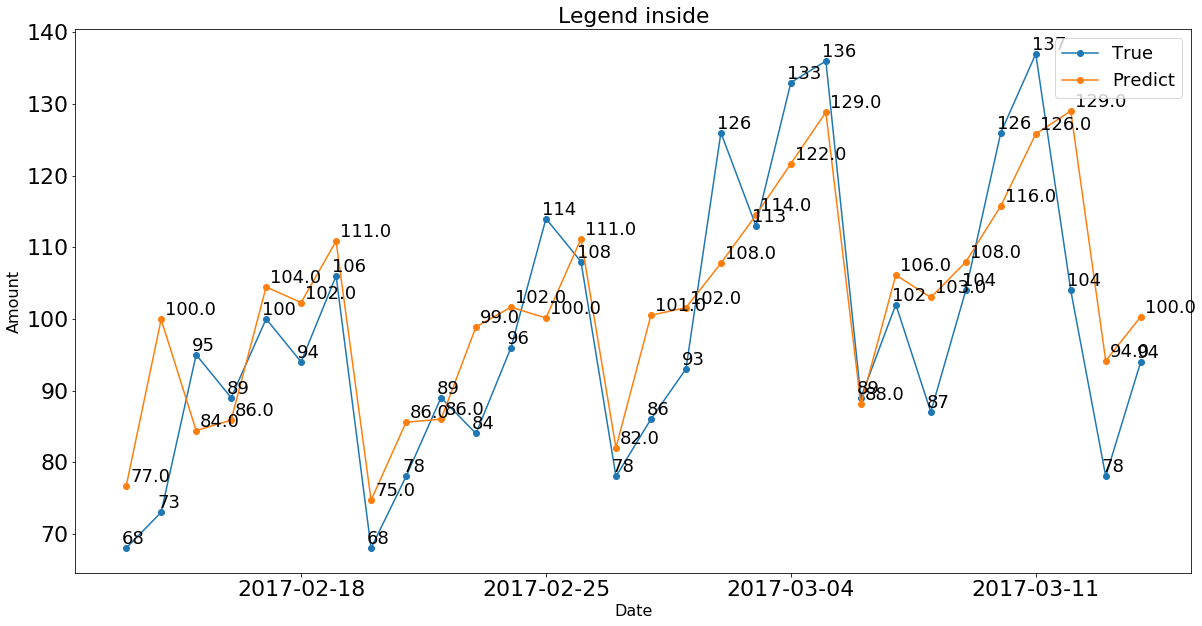

Iteration: 111
Part: 0; MAPE: 5.214859;     Naive: 15.171351; MA: 10.192392
Part: 1; MAPE: 5.699732;     Naive: 10.611225; MA: 6.647719
Part: 2; MAPE: 5.385058;     Naive: 16.534342; MA: 12.018571
*************Total MAPE: 5.433216***************; Naive: 14.105639; MA: 9.619561


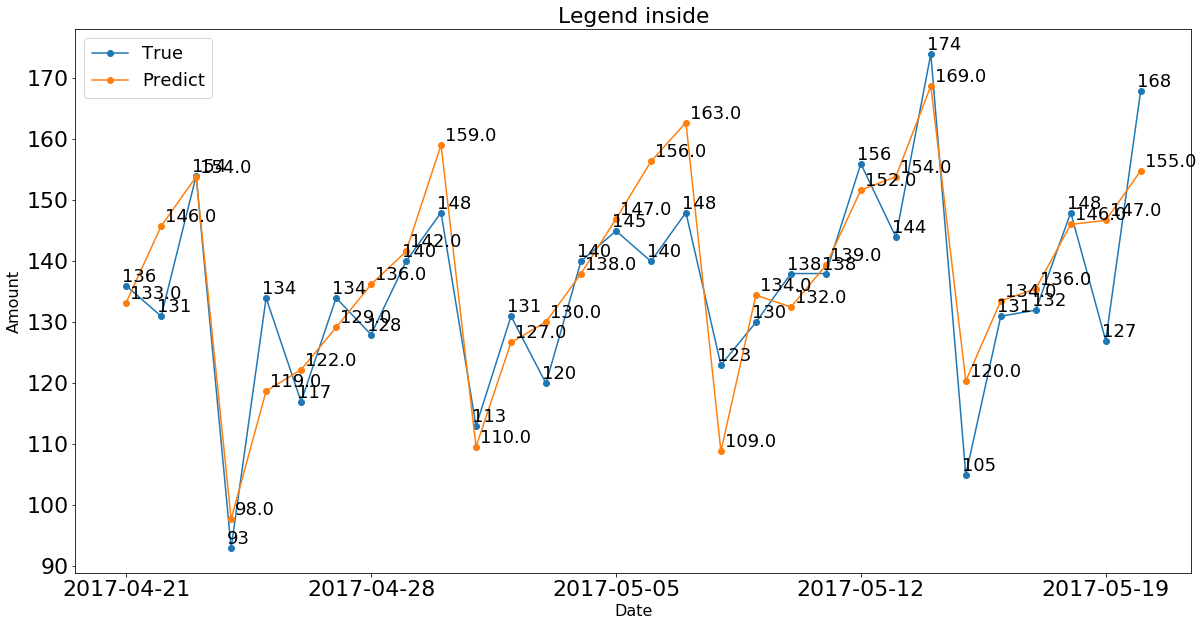

Iteration: 222
Part: 0; MAPE: 7.813727;     Naive: 15.477355; MA: 15.391129
Part: 1; MAPE: 8.033309;     Naive: 14.799419; MA: 12.021788
Part: 2; MAPE: 8.352175;     Naive: 14.414476; MA: 12.050699
*************Total MAPE: 8.066404***************; Naive: 14.897083; MA: 13.154538


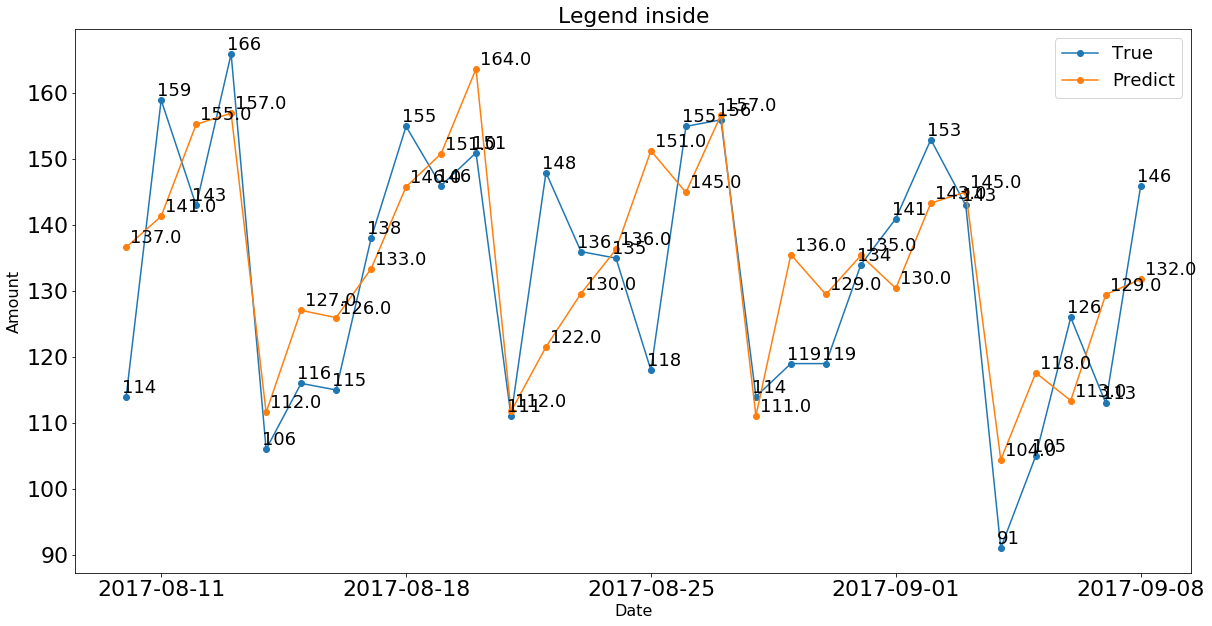

Iteration: 230
Part: 0; MAPE: 7.498913;     Naive: 13.481044; MA: 11.391751
Part: 1; MAPE: 7.487817;     Naive: 13.593280; MA: 12.208086
Part: 2; MAPE: 7.704101;     Naive: 15.505885; MA: 11.137244
*************Total MAPE: 7.563610***************; Naive: 14.193403; MA: 11.579027


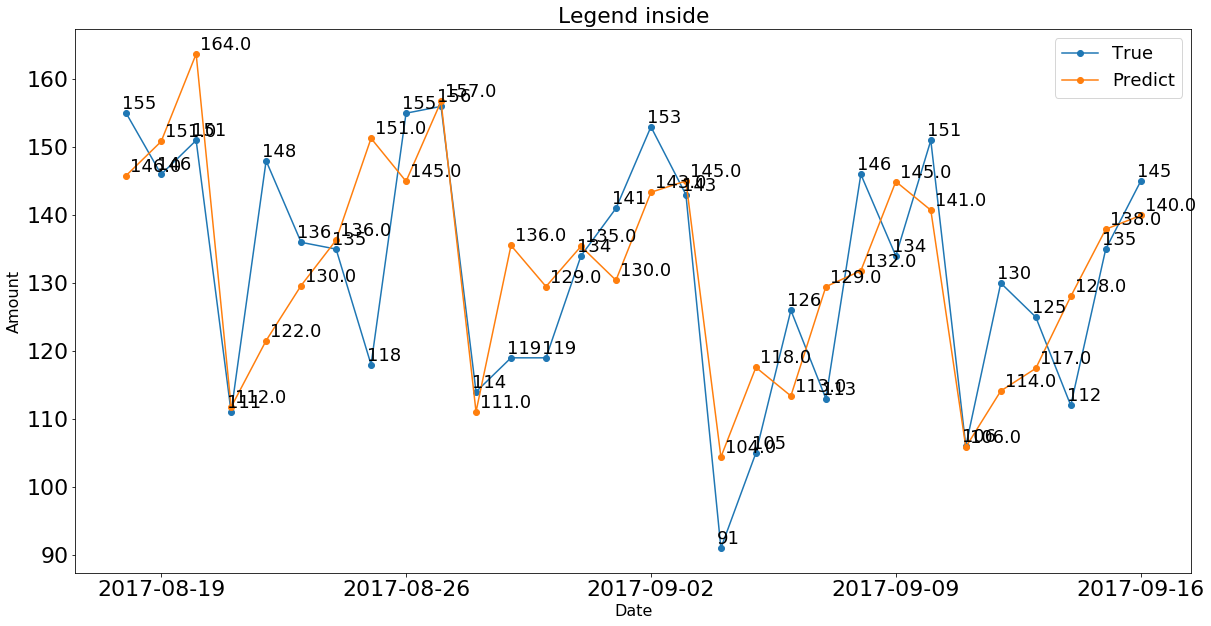

Iteration: 303
Part: 0; MAPE: 5.516535;     Naive: 18.490821; MA: 11.230597
Part: 1; MAPE: 5.112398;     Naive: 13.187420; MA: 10.005437
Part: 2; MAPE: 5.379568;     Naive: 13.709895; MA: 8.730102
*************Total MAPE: 5.336167***************; Naive: 15.129378; MA: 9.988712


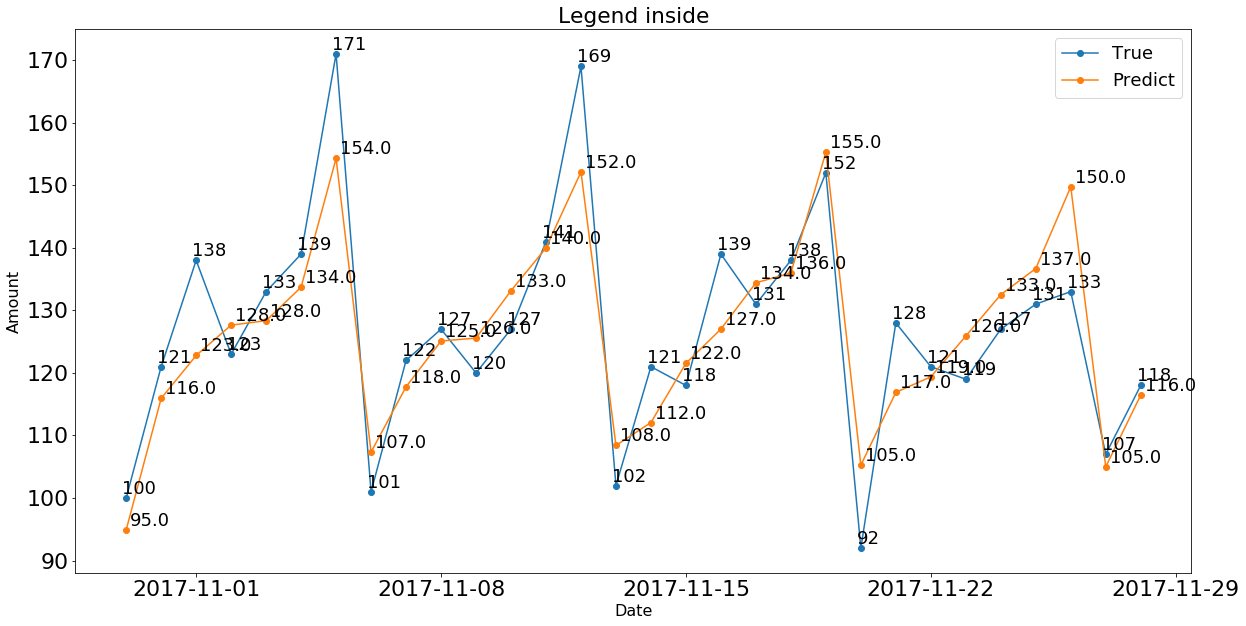

Best MAPE iteration: 109; Value: 5.042297


In [28]:
# go through all test data in small snippets and return local MAPE

# MA
rolling_size = 7
df_moving_average = pre_train_0815.copy()
predict_ma = df_moving_average['sales'].rolling(window=rolling_size).mean()
predict_ma_test = predict_ma.iloc[1459:-1].values
# Naive
predict_naive_test = pre_train_0815['sales'][1459:-1]


def local_mape(data, labels, model, size_part, parts, thres, pred_naive, pred_ma, data_raw):
    min_mape = float("Inf")
    mape_part = np.empty([parts, 1])
    mape_naive_part = np.empty([parts, 1])
    mape_ma_part = np.empty([parts, 1])
    predict = model.predict(xgb.DMatrix(data.values))
    predict_naive = pred_naive
    predict_ma = pred_ma
    for i in range(len(data)-size_part*parts):
        mape_total = mape_fast(predict[i:i+size_part*parts], labels[i:i+size_part*parts].values)
        mape_naive_total = mape_fast(predict_naive[i:i+size_part*parts].values, labels[i:i+size_part*parts].values)
        mape_ma_total = mape_fast(predict_ma[i:i+size_part*parts], labels[i:i+size_part*parts].values)
        for j in range(parts):
            mape_part[j,0] = mape_fast(predict[i+int(size_part*j):i+int(size_part*(j+1))], labels[i+int(size_part*j):i+int(size_part*(j+1))].values)  
            mape_naive_part[j,0] = mape_fast(predict_naive[i+int(size_part*j):i+int(size_part*(j+1))].values, labels[i+int(size_part*j):i+int(size_part*(j+1))].values)  
            mape_ma_part[j,0] = mape_fast(predict_ma[i+int(size_part*j):i+int(size_part*(j+1))], labels[i+int(size_part*j):i+int(size_part*(j+1))].values)  
        if mape_total < min_mape:
            min_mape = mape_total
            best_mape_iter = i
        if np.all(abs(mape_part - mape_total) <= thres):
            print("Iteration: %d" %i)
            for j in range(parts):
                print("Part: %d; MAPE: %f;     Naive: %f; MA: %f" %(j, mape_part[j,0], mape_naive_part[j,0], mape_ma_part[j,0]))             
            print("*************Total MAPE: %f***************; Naive: %f; MA: %f" %(mape_total, mape_naive_total, mape_ma_total))
            plot_partial_graph(data_raw, predict, i, size_part*parts)
        
    print("Best MAPE iteration: %d; Value: %f" %(best_mape_iter, min_mape))
  
local_mape(test_df_reduced, y_test_0815, model_0815, 10, 3, 0.3, predict_naive_test, predict_ma_test, test_0815)

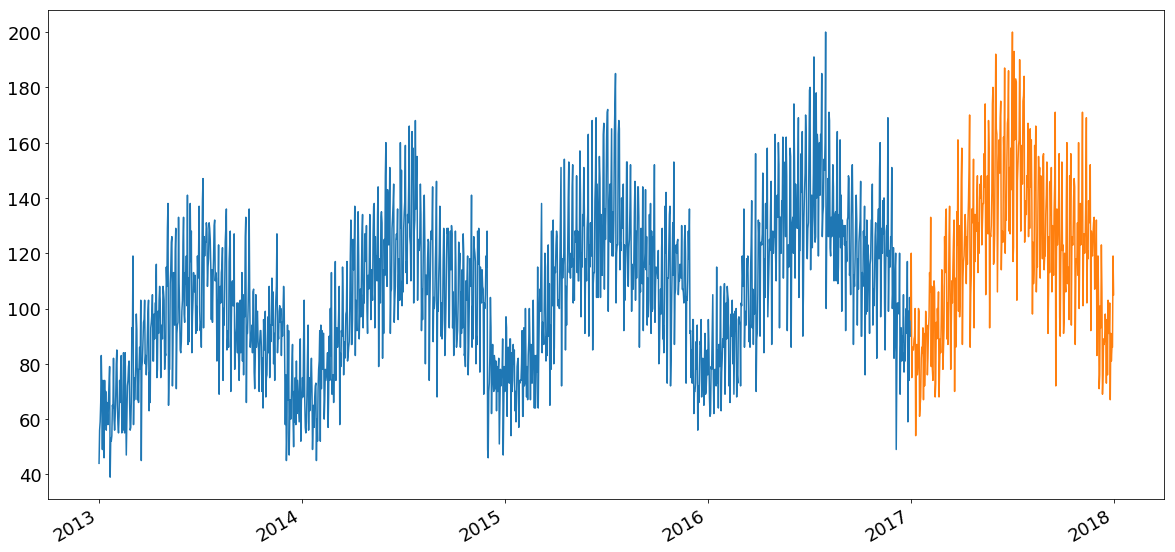

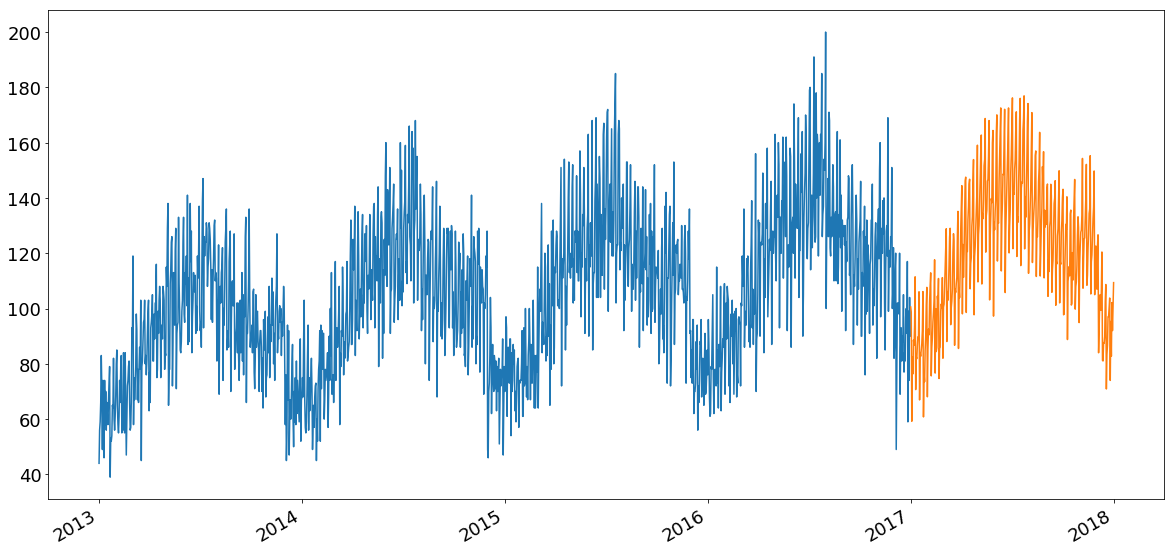

In [30]:
# Plotting actual time series (blue=training area, orange=prediction area)
fig = plt.figure(figsize=(20,10))
plt.plot(train_0815.date, train_0815.sales)
plt.plot(test_0815.date, test_0815.sales)

plt.gcf().autofmt_xdate()
plt.show()

# Plotting actual train time series (blue) and test/predicted part (orange)
fig = plt.figure(figsize=(20,10))
plt.plot(train_0815.date, train_0815.sales)
plt.plot(test_0815.date, predict)

plt.gcf().autofmt_xdate()


plt.show()

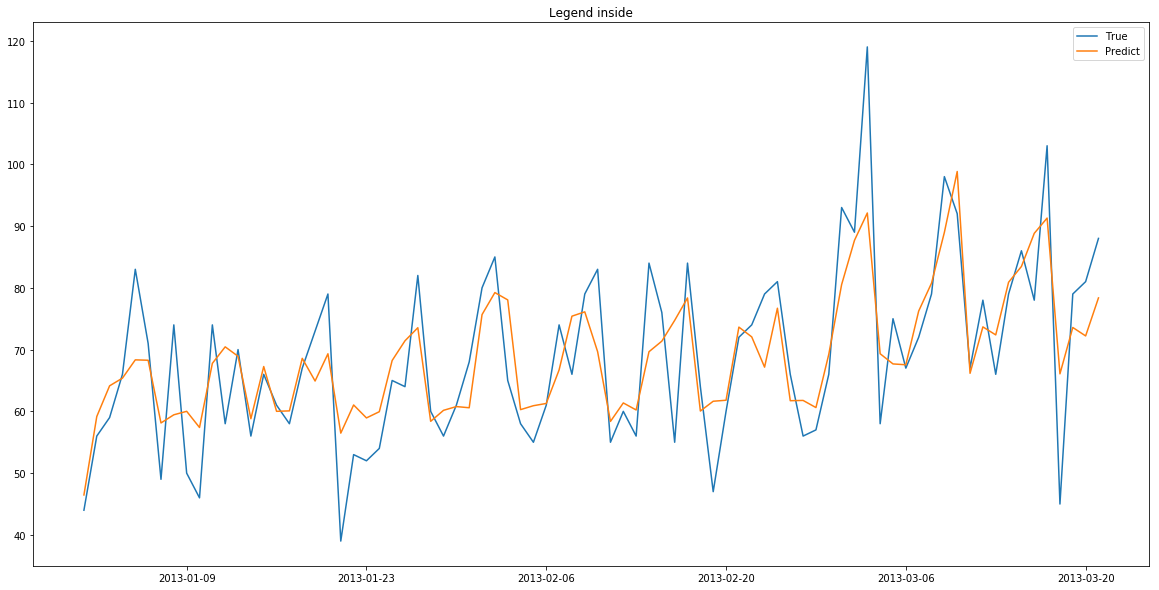

In [27]:
# Show excerpt of training actuals vs prediction
len_show = 80
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(train_0815.date[:len_show], train_0815['sales'][:len_show], label='True')
ax.plot(train_0815.date[:len_show], predict_train[:len_show], label='Predict')
plt.title('Legend inside')
ax.legend()
plt.show()

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



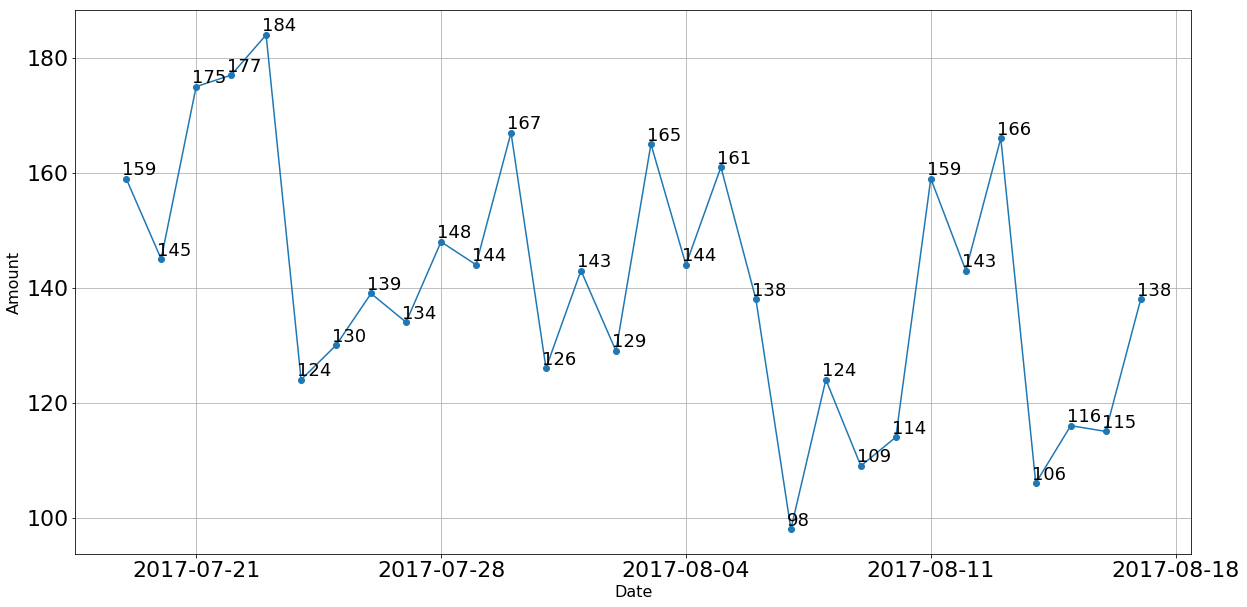

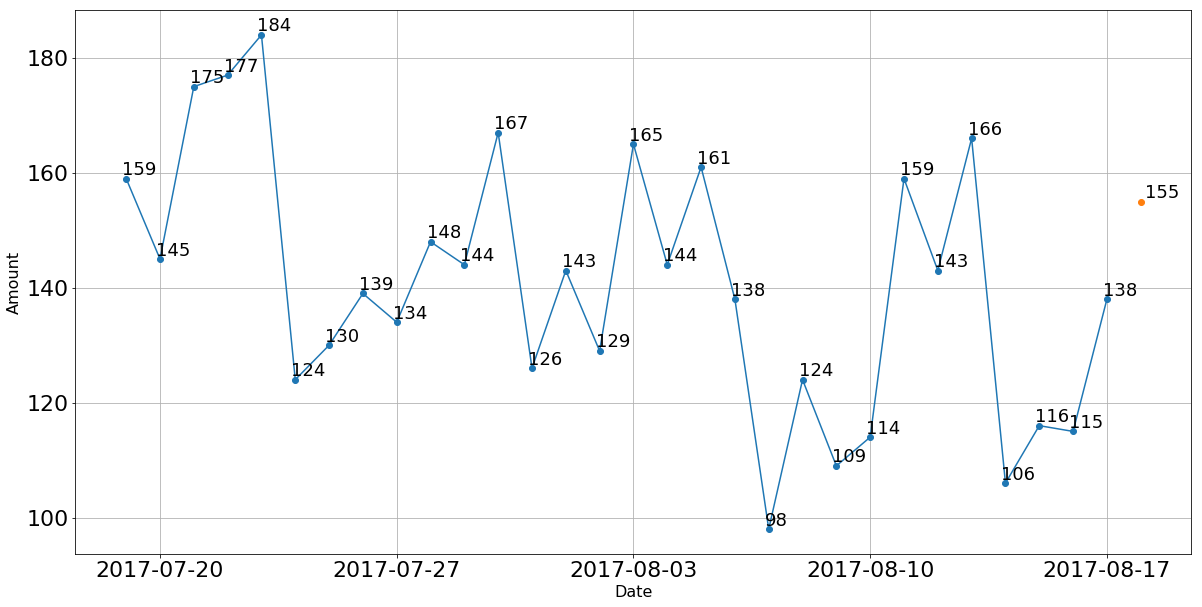

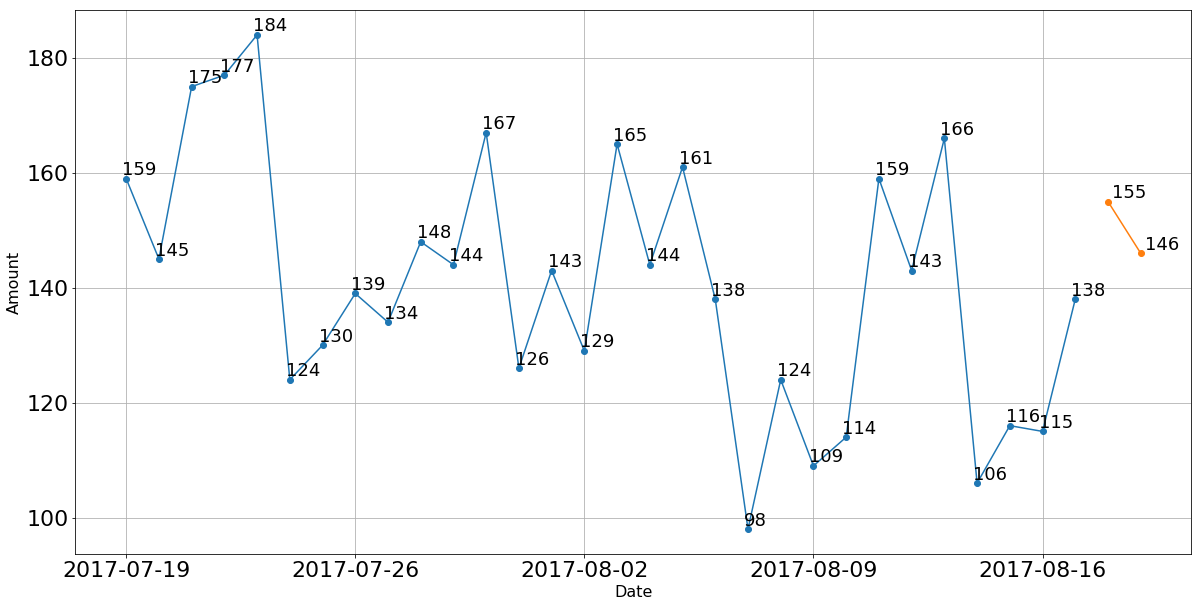

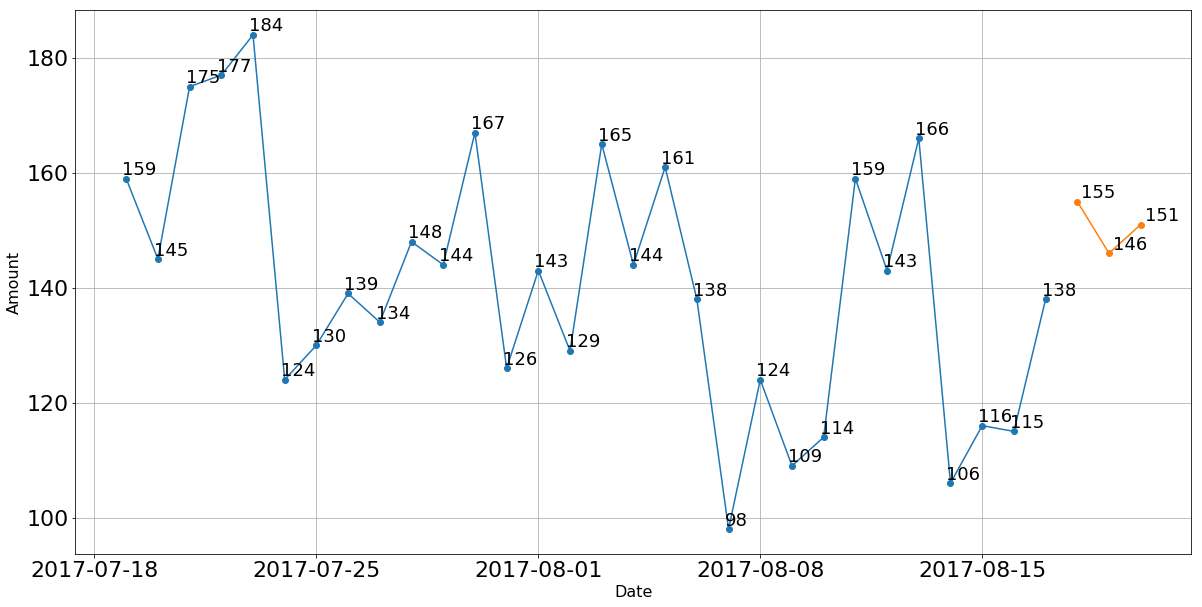

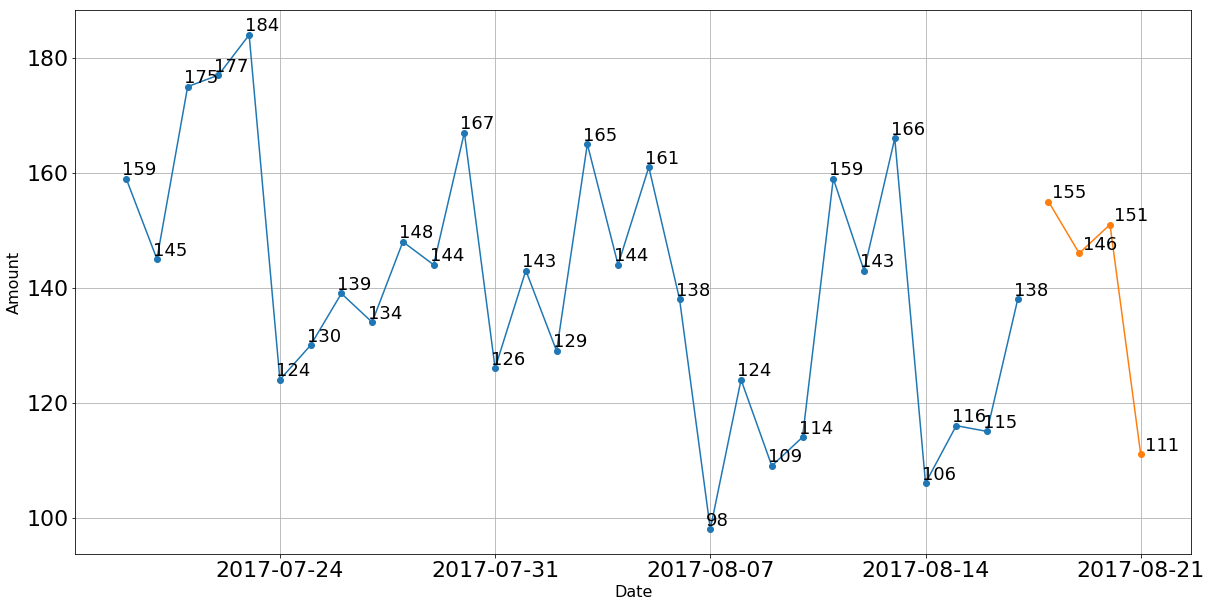

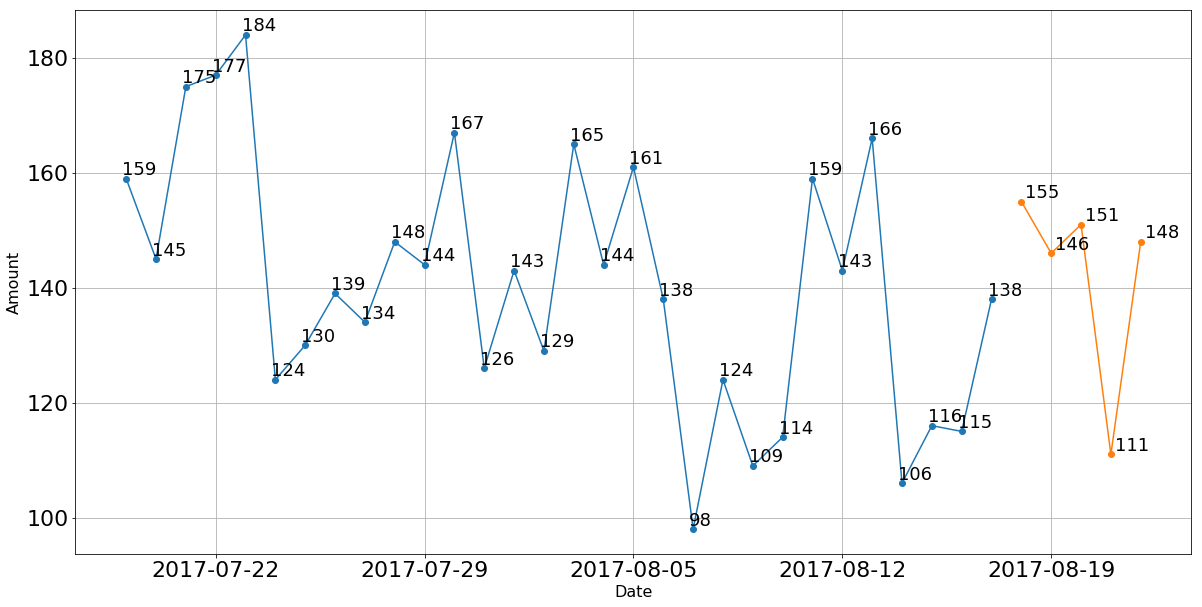

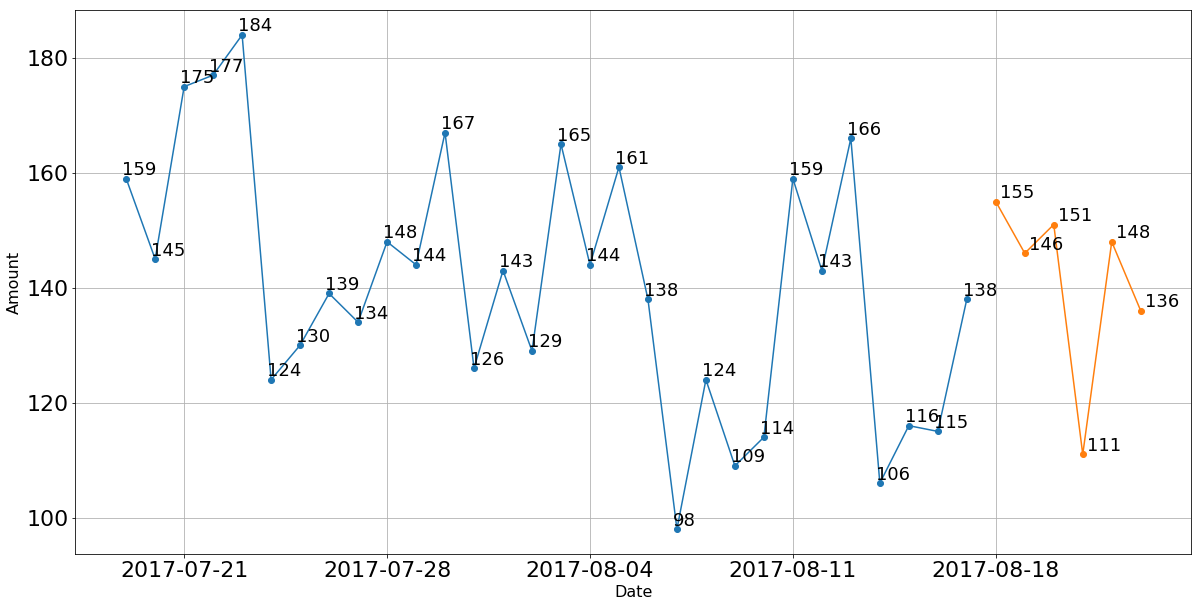

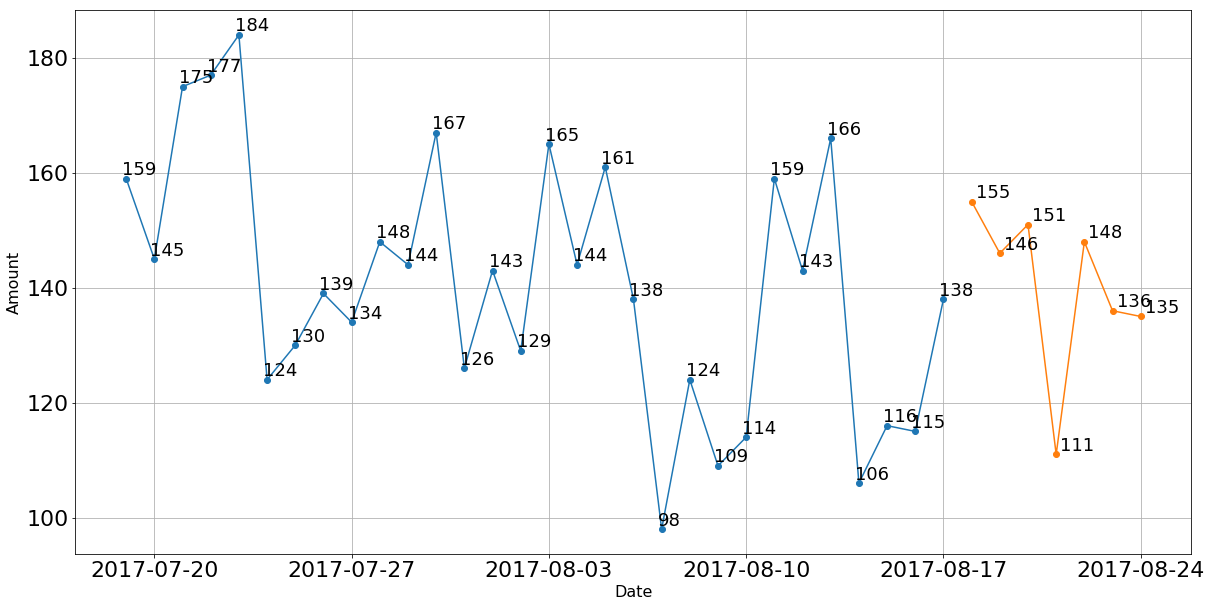

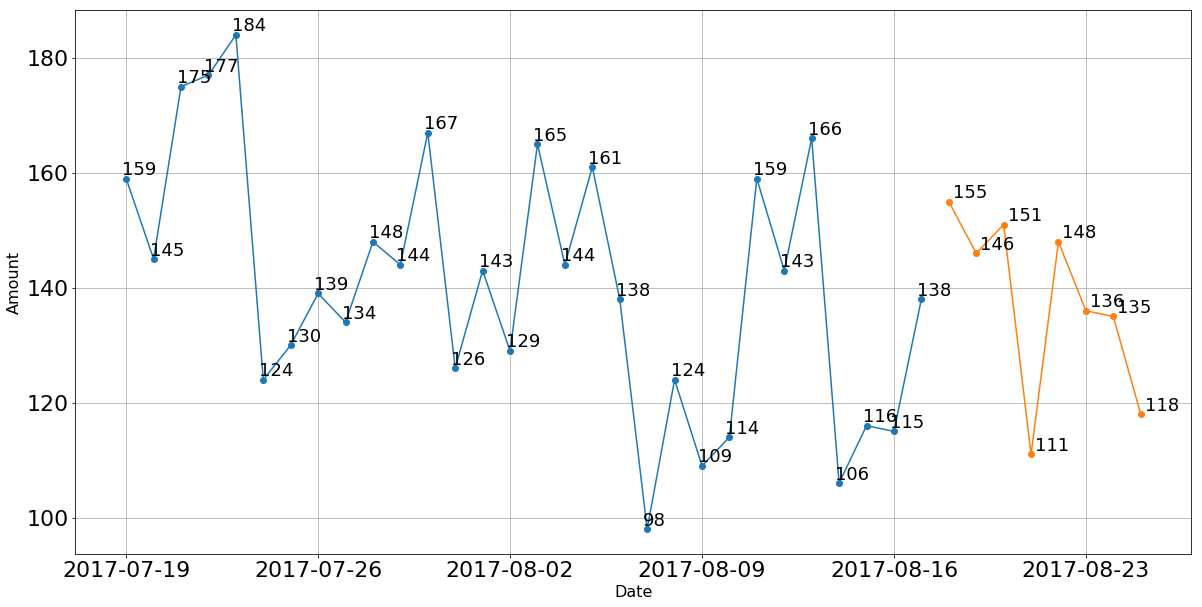

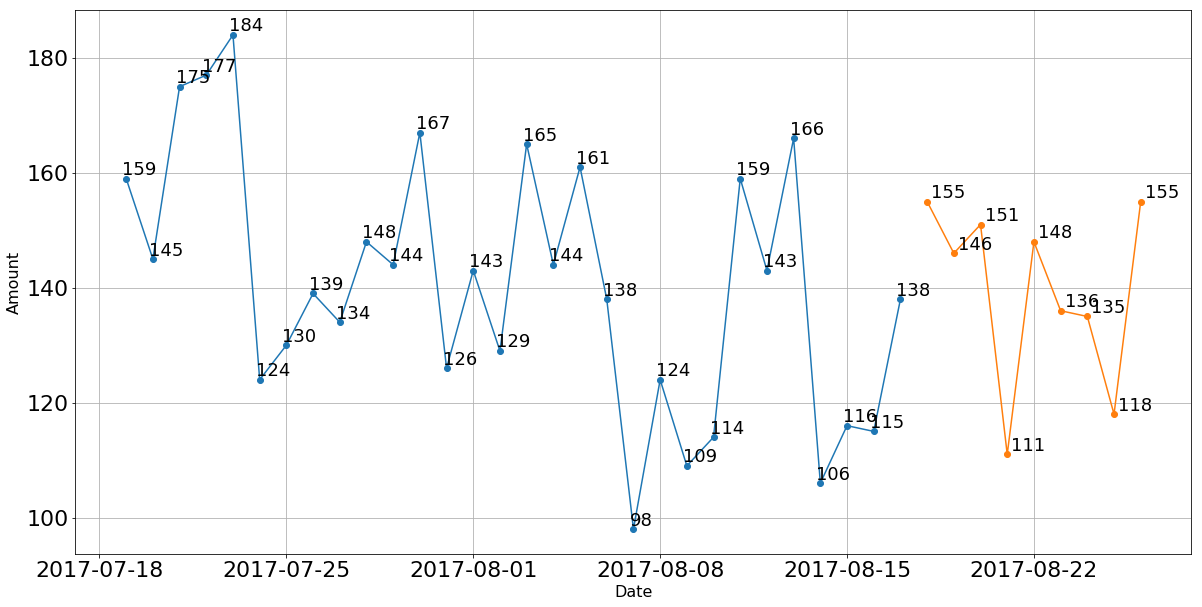

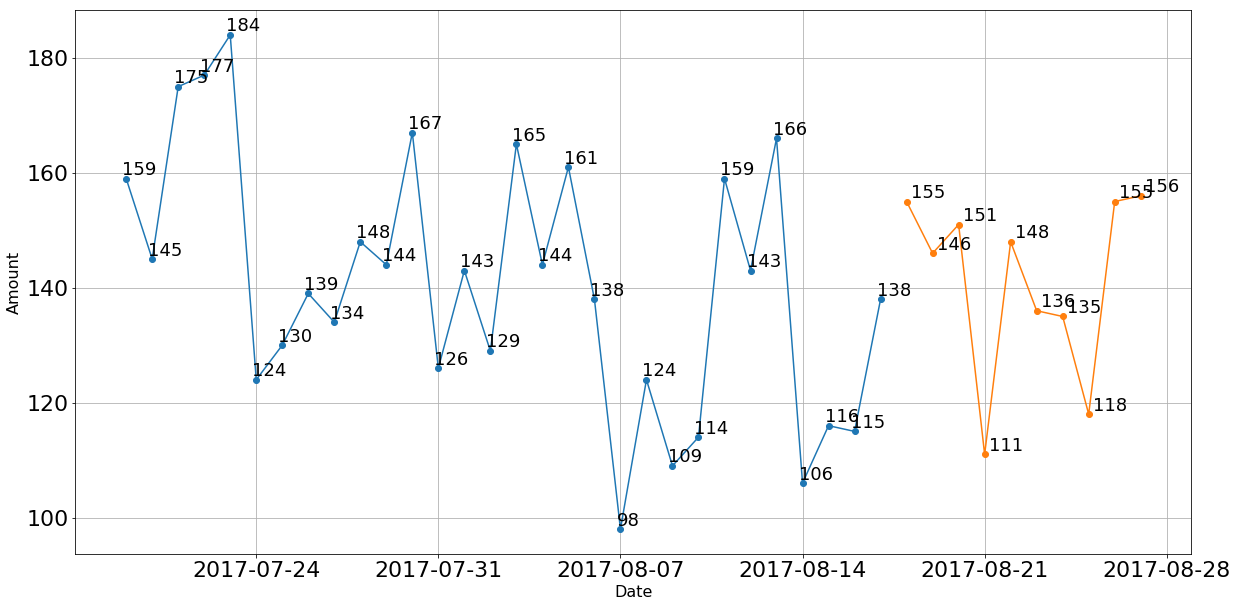

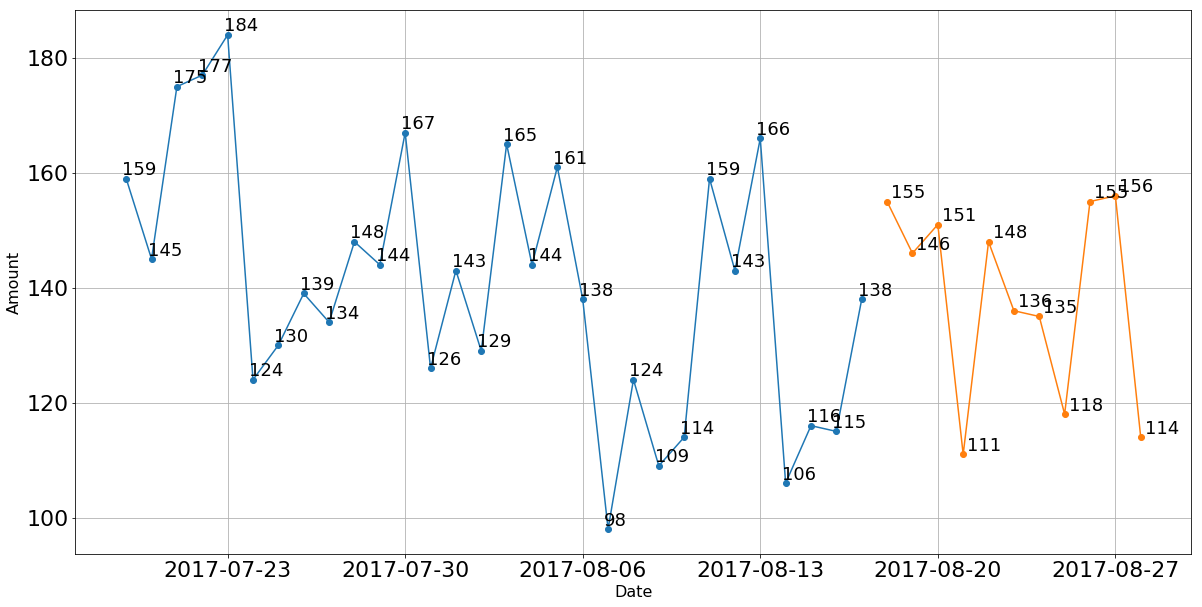

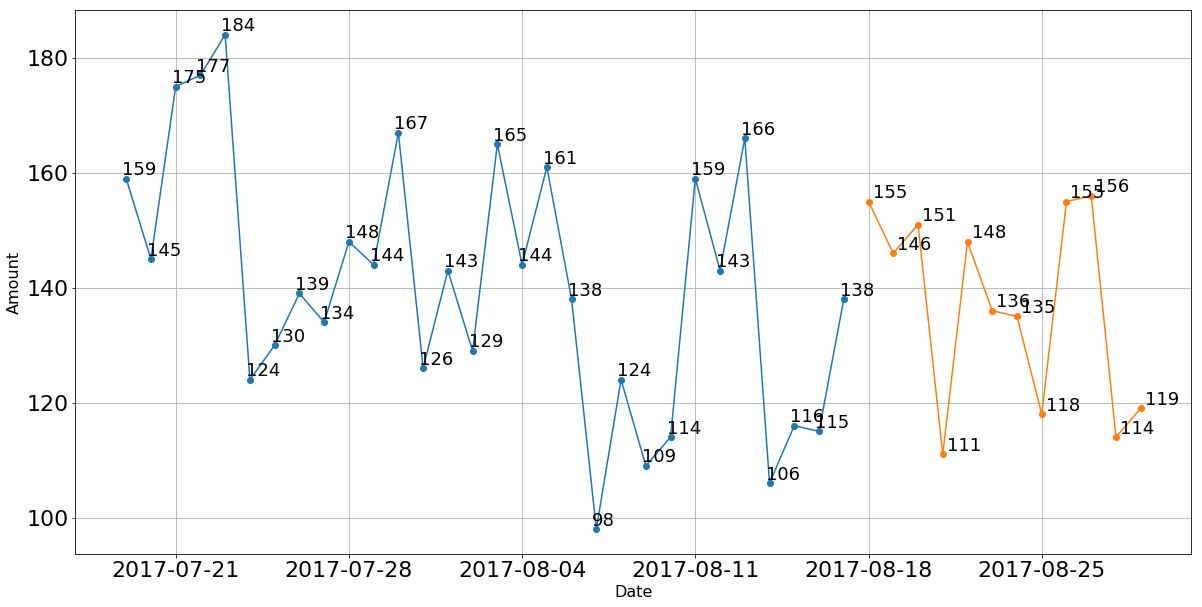

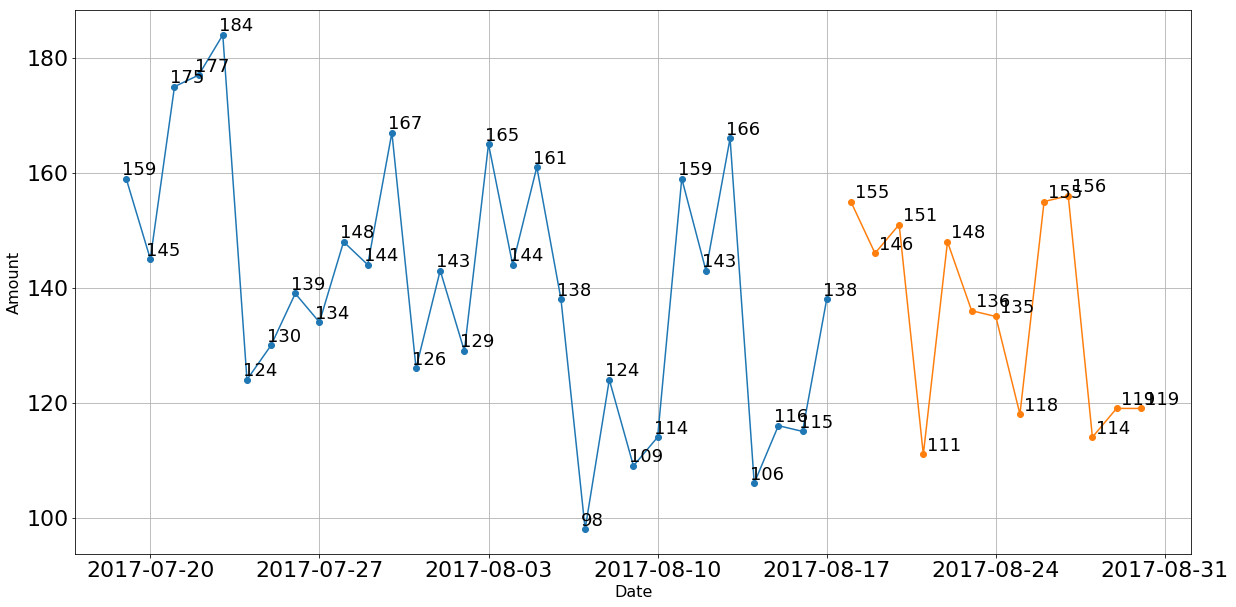

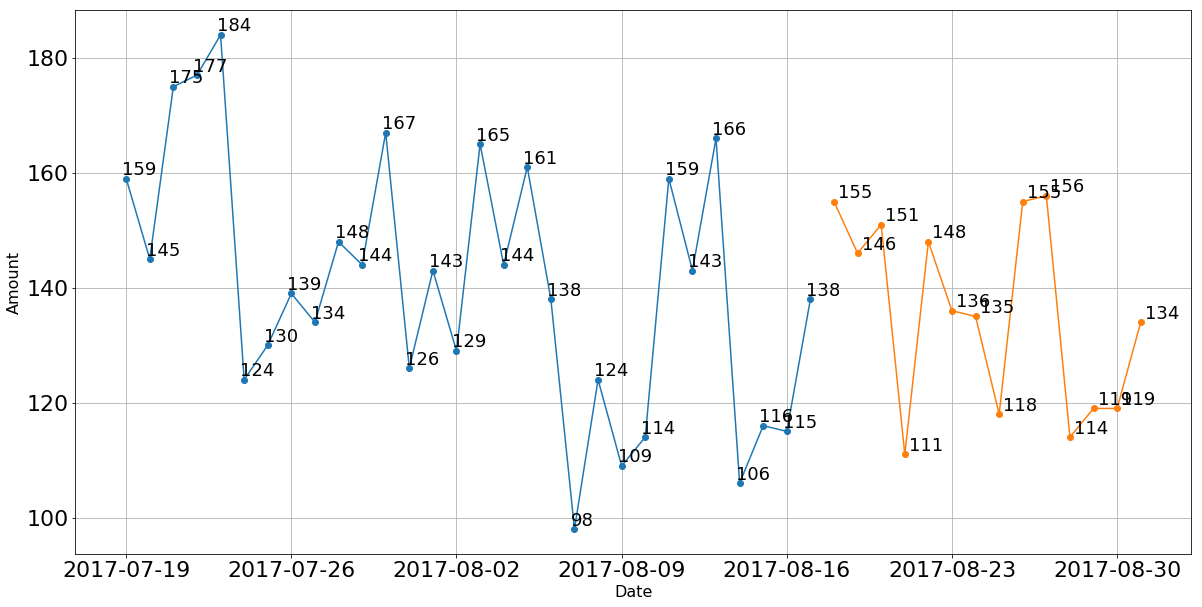

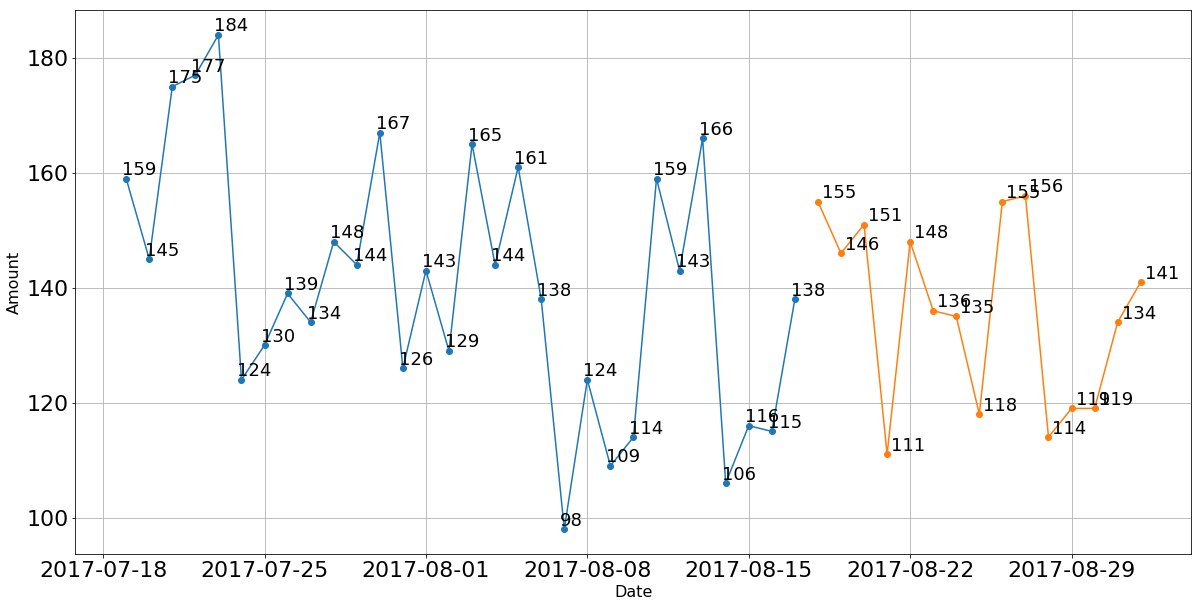

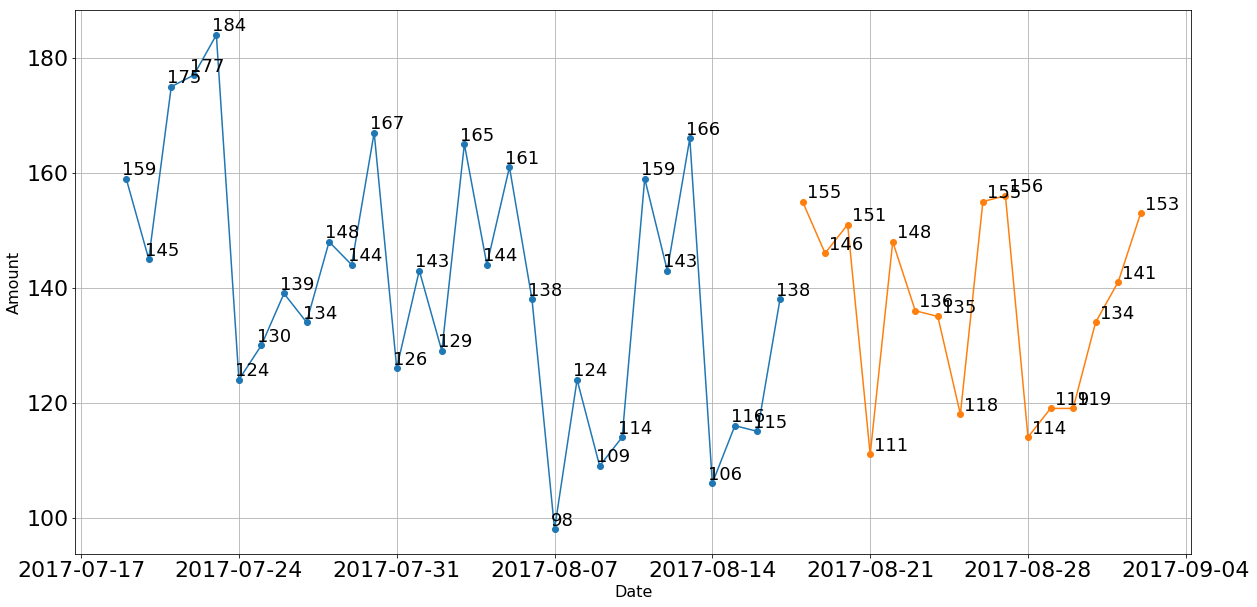

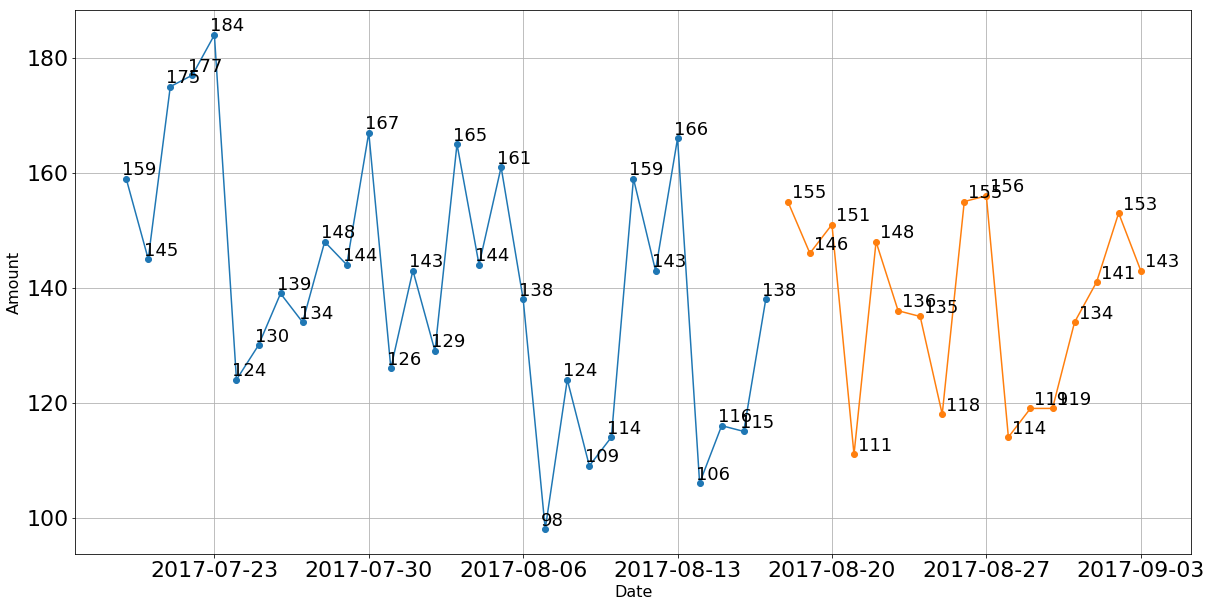

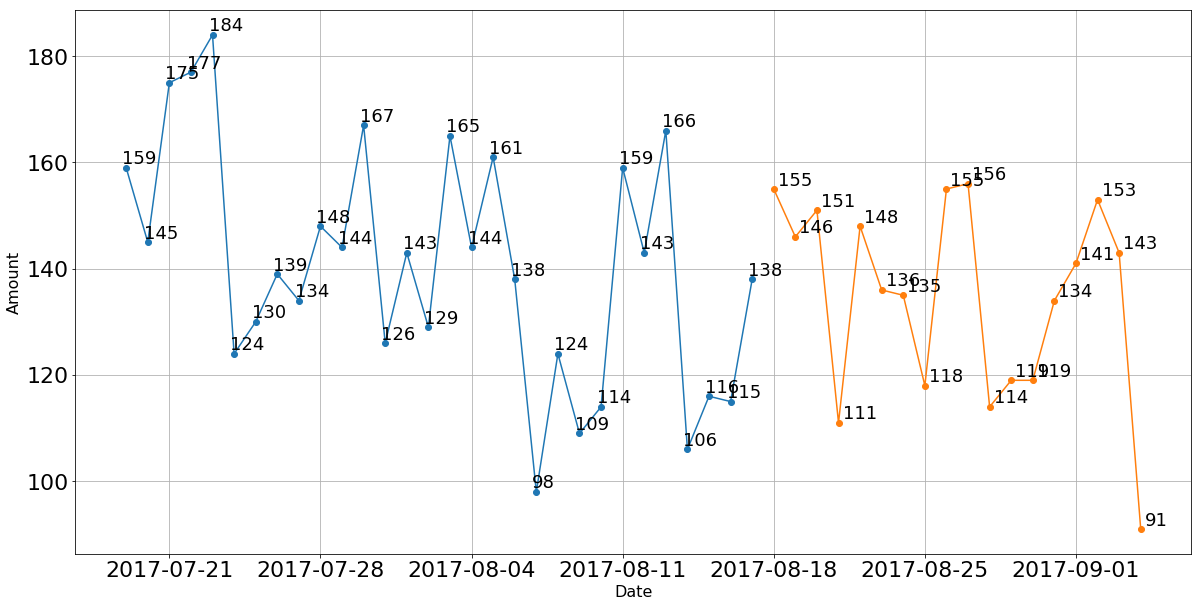

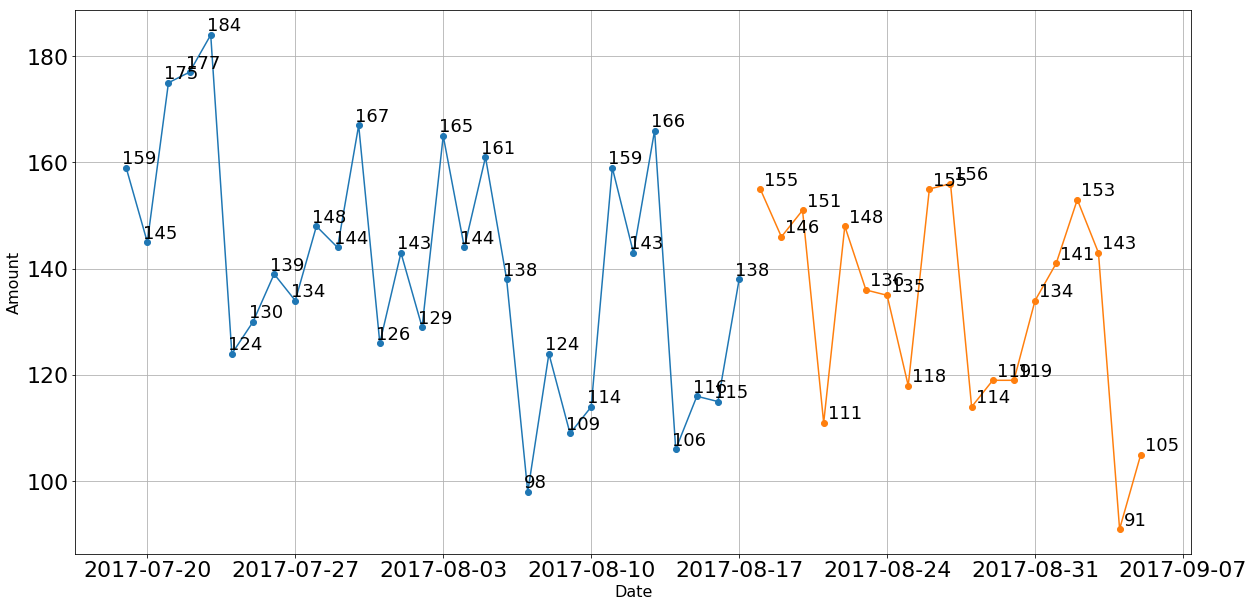

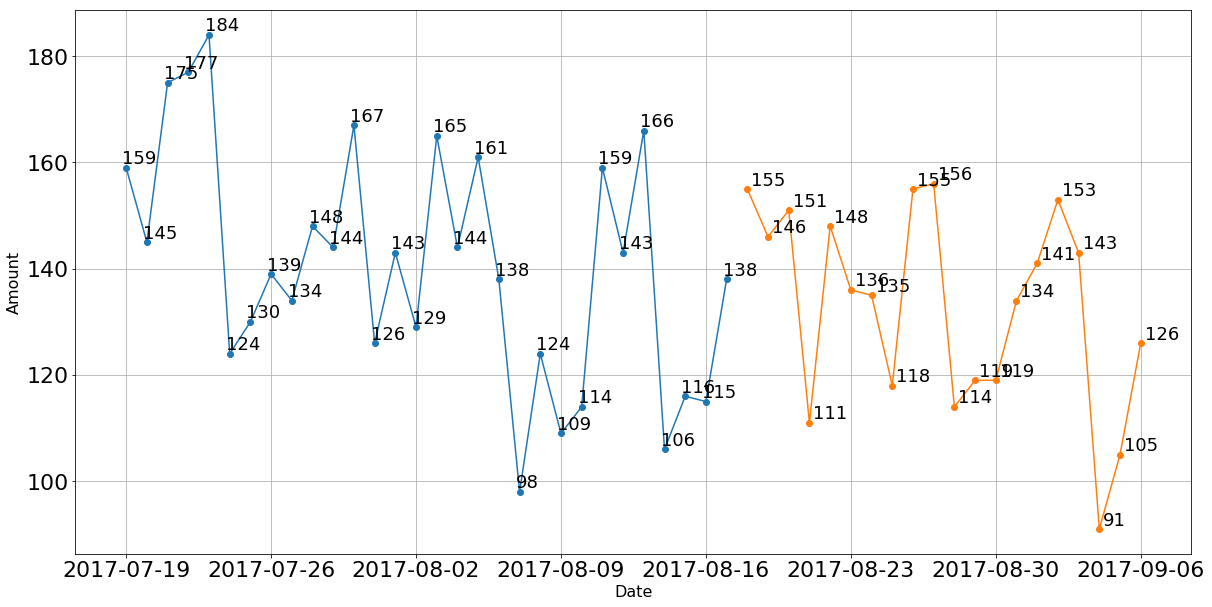

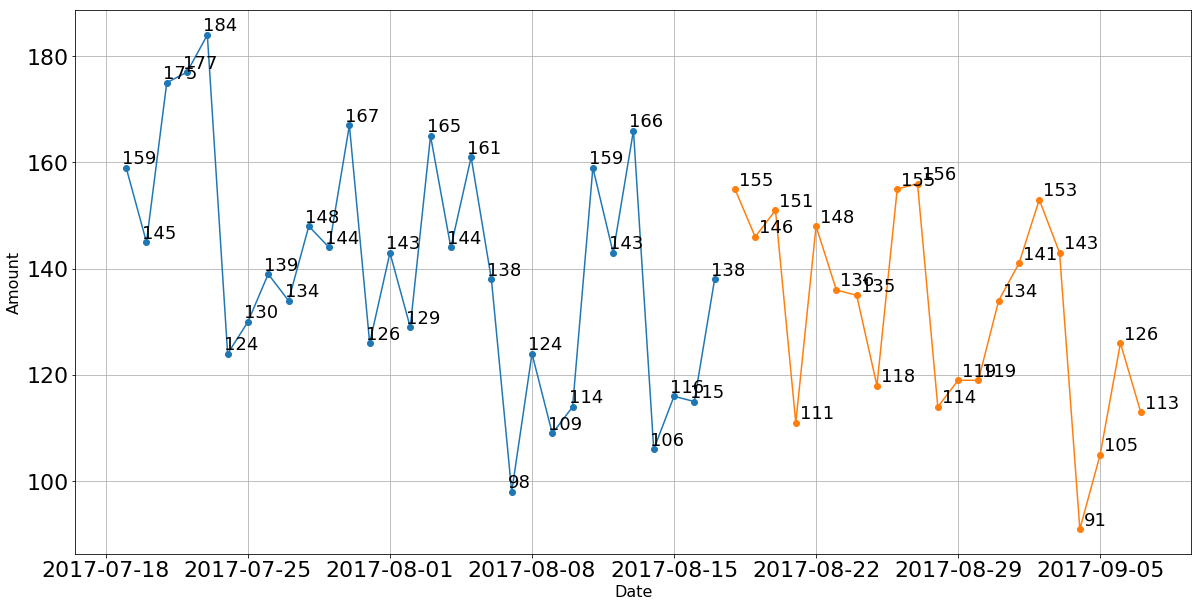

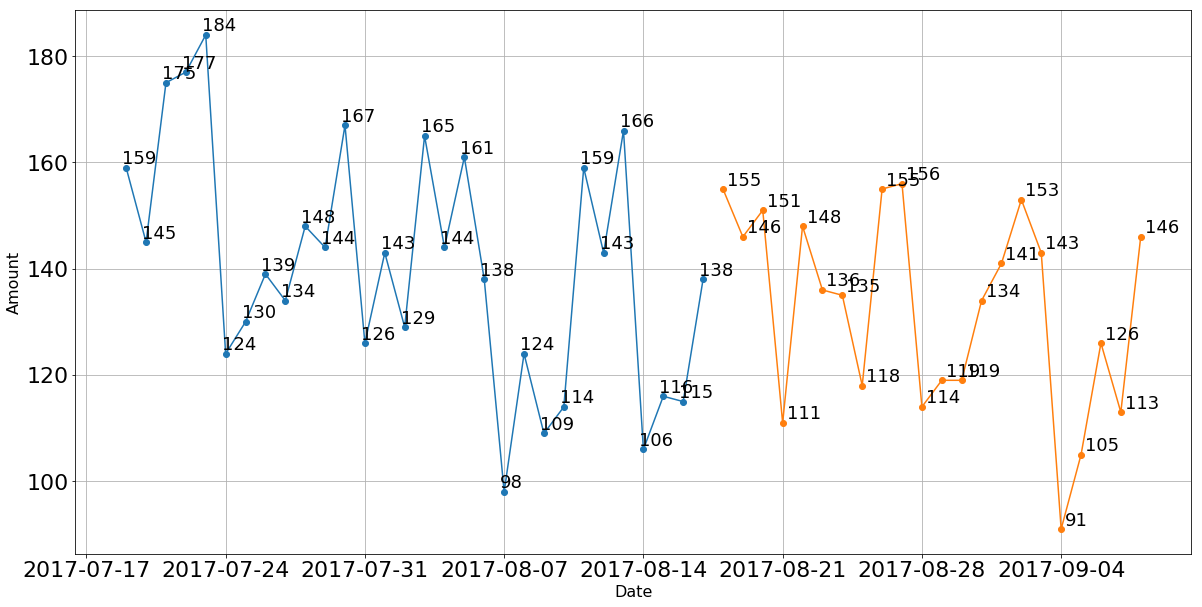

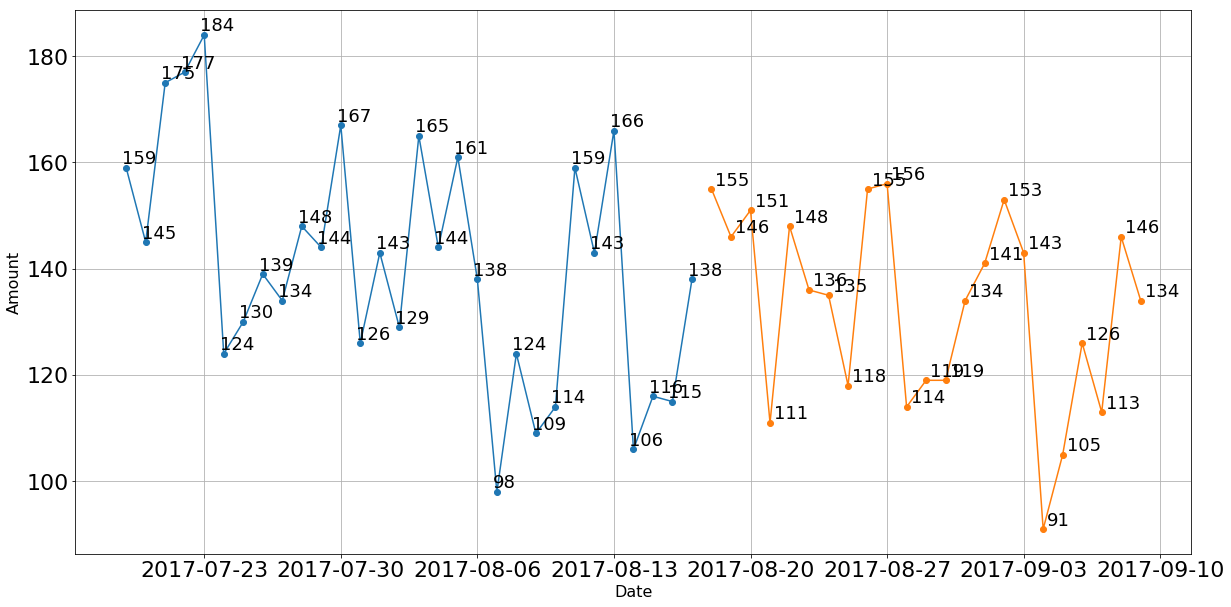

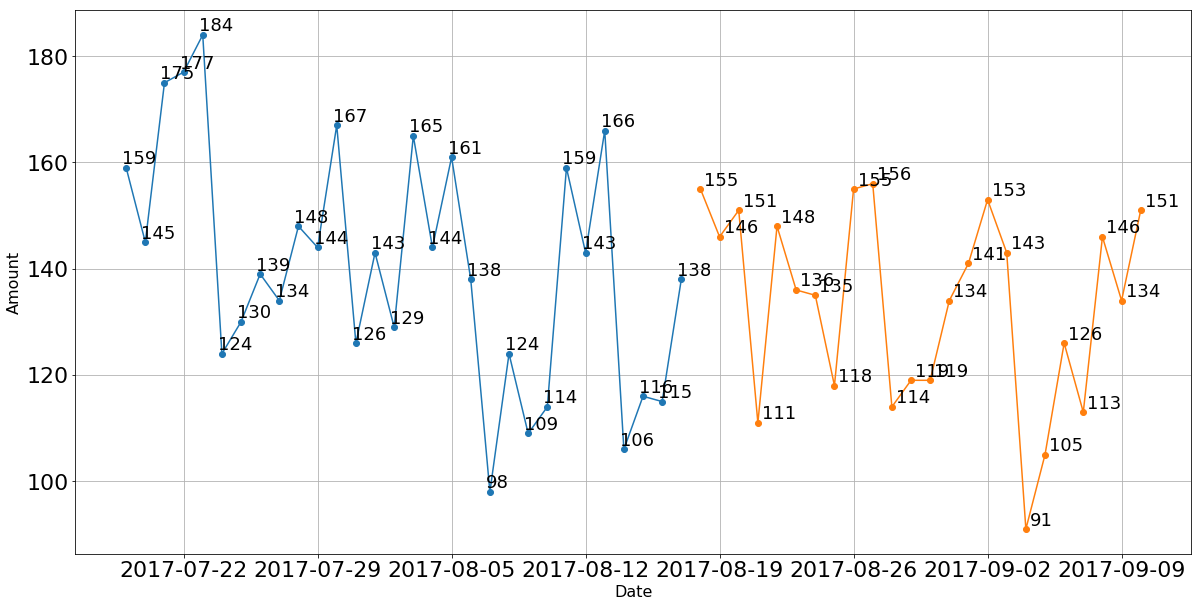

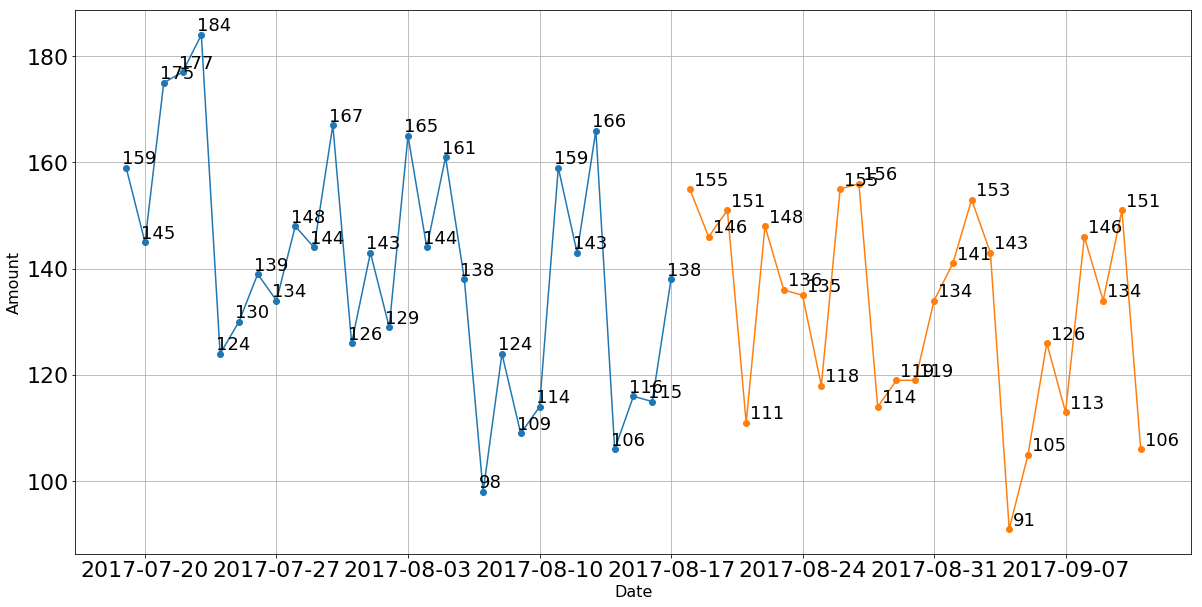

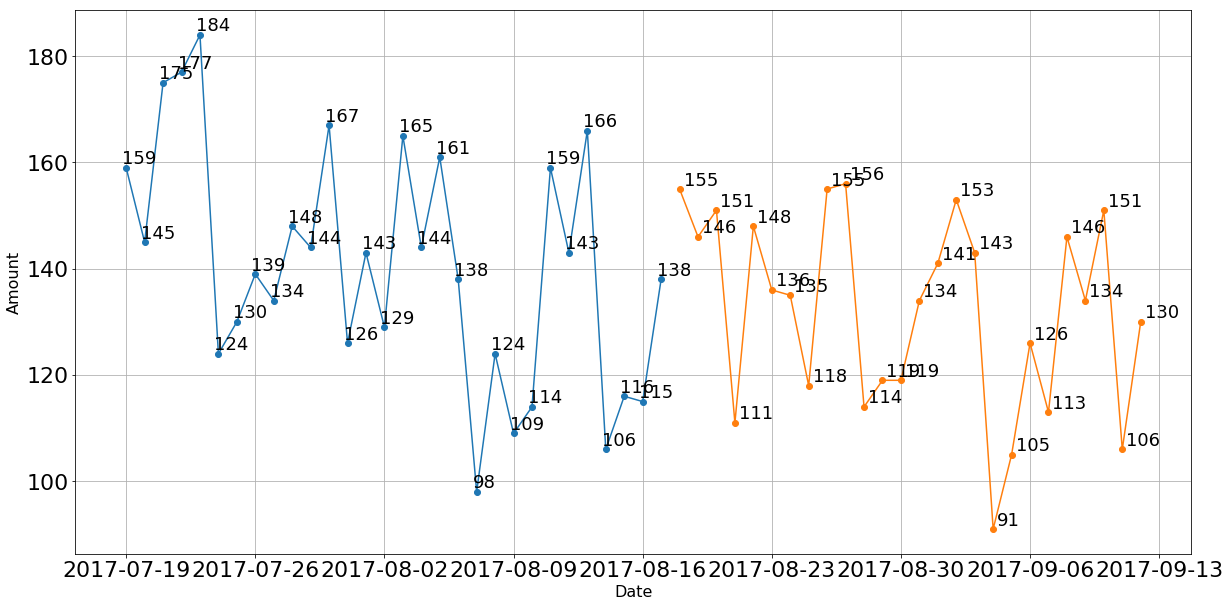

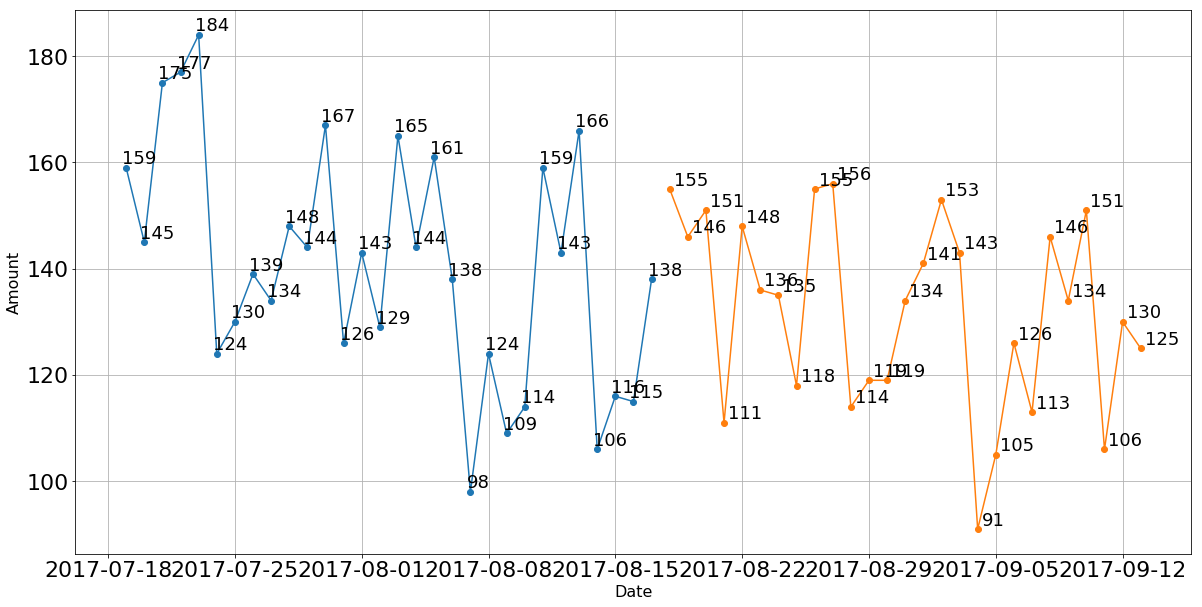

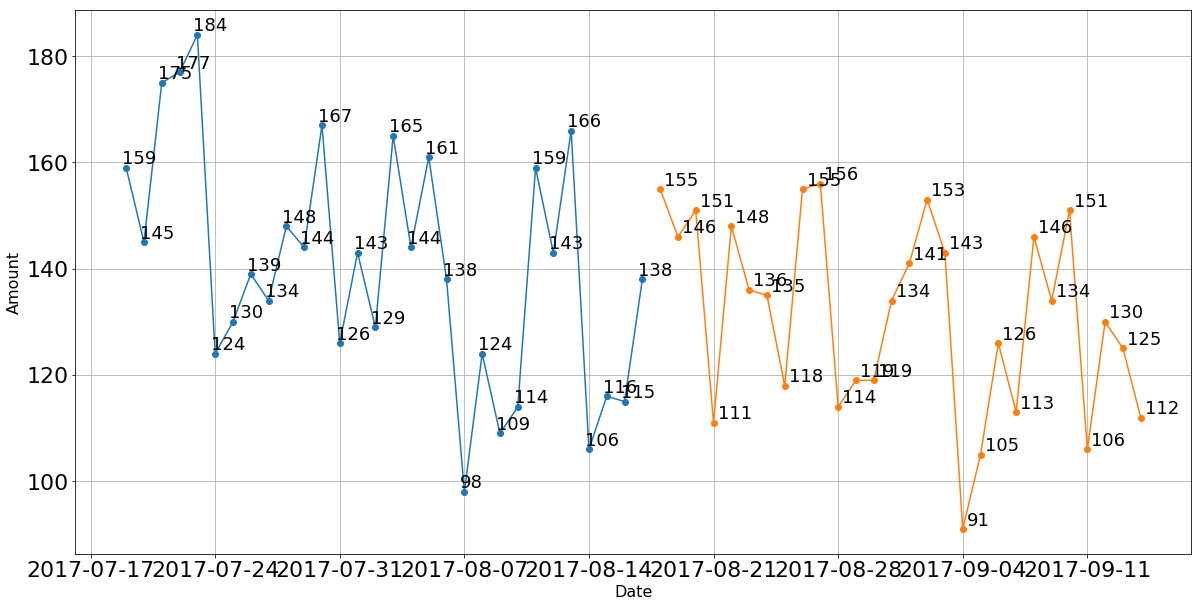

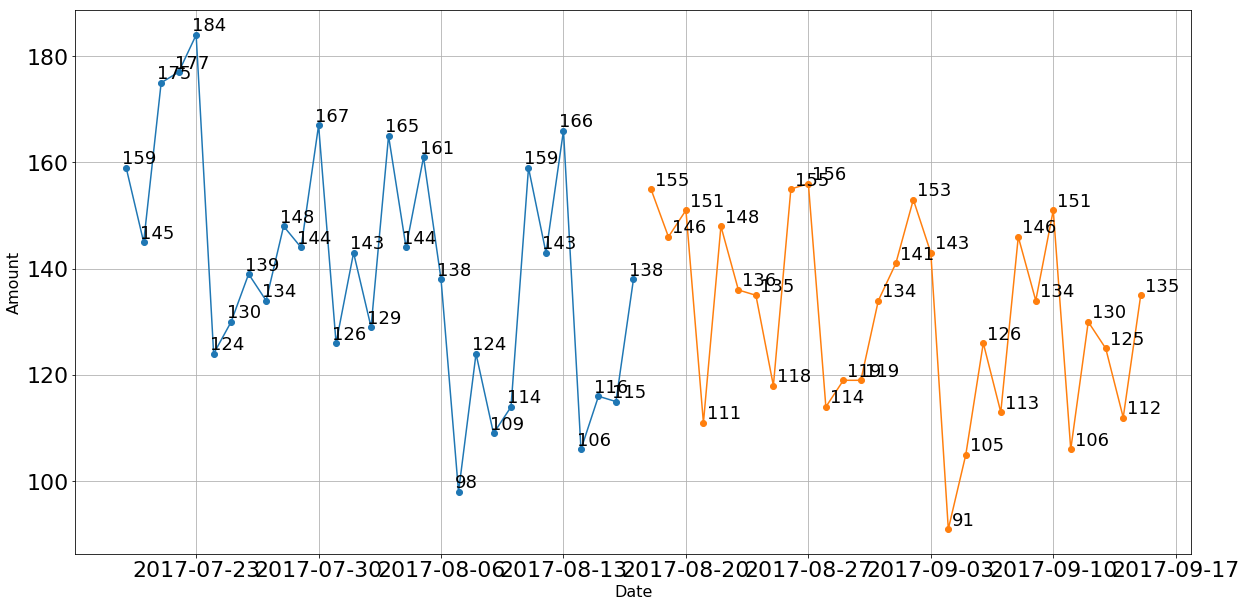

In [149]:
# plot creation for exporting to experiment 

def save_figs_experiment(data, start, length, steps):
    len_show = length
    start_show = start
    steps_show = steps
    

    for i in range(steps_show):
        # fig properties
        fig = plt.figure(figsize=(20,10))
        plt.rcParams.update({'font.size': 18})
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Amount', fontsize=16)
        ax = fig.add_subplot(111)
        ax.tick_params(axis='x', labelsize=22)
        ax.tick_params(axis='y', labelsize=22)
        
        plt.plot(data.date[start_show:start_show+len_show], data['sales'][start_show:start_show+len_show], marker = 'o')
        plt.plot(data.date[start_show+len_show:start_show+len_show+i], data['sales'][start_show+len_show:start_show+len_show+i], marker = 'o')
        #plt.plot(test_0815.date[start_show:start_show+len_show],predict[0][start_show:start_show+len_show])
        for x, y in zip(data.date[start_show:start_show+len_show], data['sales'][start_show:start_show+len_show]):                                       # <--
            ax.annotate('%s' % y, xy=(x,y), xytext = (-4,4), textcoords='offset points') # <--
        for x, y in zip(data.date[start_show+len_show:start_show+len_show+i], data['sales'][start_show+len_show:start_show+len_show+i]):                                       # <--
            ax.annotate('%s' % y, xy=(x,y), xytext = (4,4), textcoords='offset points') # <--
        #plt.plot(test_0815.date[start_show:start_show+len_show], predict[start_show:start_show+len_show])
        #for x, y in zip(test_0815.date[start_show:start_show+len_show],predict[0][start_show:start_show+len_show]):                                       # <--
        #    ax.annotate('(%s)' % y, xy=(x,y), textcoords='data') # <--

        plt.grid()
        plt.show()
        # uncomment so safe figures
        #fig.savefig("foo.pdf", bbox_inches='tight')
        #fig.savefig("foo_" + str(i) + ".png")

save_figs_experiment(test_0815, 200, 30, 30)    

In [31]:
# Naive forecasting as baseline
predict_naive_train = pre_train_0815['sales'][:1459]
predict_naive_test = pre_train_0815['sales'][1459:-1]

smape_naive_train = smape_fast(y_train_0815[1:].values, predict_naive_train.values)
smape_naive_test = smape_fast(y_test_0815.values, predict_naive_test.values)
mape_naive_train = mape_fast(y_train_0815[1:].values, predict_naive_train.values)
mape_naive_test = mape_fast(y_test_0815.values, predict_naive_test.values)

print("Naive SMAPE test:%f; train:%f\nMAPE test:%f; train:%f" %(smape_naive_test, smape_naive_train, mape_naive_test, mape_naive_train))

# Moving average as baseline
rolling_size = 7
df_moving_average = pre_train_0815.copy()
predict_ma = df_moving_average['sales'].rolling(window=rolling_size).mean()

smape_ma_train = smape_fast(y_train_0815[rolling_size:].values, predict_ma.iloc[rolling_size-1:1459].values)
smape_ma_test = smape_fast(y_test_0815.values, predict_ma.iloc[1459:-1].values)
mape_ma_train = mape_fast(y_train_0815[rolling_size:].values, predict_ma.iloc[rolling_size-1:1459].values)
mape_ma_test = mape_fast(y_test_0815.values, predict_ma.iloc[1459:-1].values)

print("Moving Avg SMAPE test:%f; train:%f\nMAPE test:%f; train:%f" %(smape_ma_test, smape_ma_train, mape_ma_test, mape_ma_train))

# Total rolling mean lag as baseline
smape_trml_train = smape_fast(y_train_0815[1:].values, train_0815['total_rolling_mean_lag'].iloc[1:].values)
smape_trml_test = smape_fast(y_test_0815.values, test_0815['total_rolling_mean_lag'].values)
mape_trml_train = mape_fast(y_train_0815[1:].values, train_0815['total_rolling_mean_lag'].iloc[1:].values)
mape_trml_test = mape_fast(y_test_0815.values, test_0815['total_rolling_mean_lag'].values)

print("Rolling Avg lag SMAPE test:%f; train:%f\nMAPE test:%f; train:%f" %(smape_trml_test, smape_trml_train, mape_trml_test, mape_trml_train))


Naive SMAPE test:16.738437; train:16.819111
MAPE test:17.981128; train:17.978111
Moving Avg SMAPE test:13.294093; train:13.560623
MAPE test:13.794540; train:14.086352
Rolling Avg lag SMAPE test:22.376280; train:21.289260
MAPE test:21.124353; train:20.633538


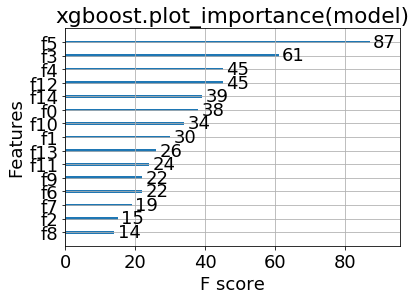

In [32]:
# xgb importance plot 
xgb.plot_importance(model_0815, max_num_features = 25)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [33]:
# preparation for SHAP
import shap

# create explanations for entrie set (train + test)
set_0815_shap = total_df_reduced.copy()


In [34]:
# create SHAP explainer and calculate SHAP values
explainer_0815 = shap.TreeExplainer(model_0815)
shap_values_0815 = explainer_0815.shap_values(set_0815_shap.values)

In [35]:
# print the JS visualization code to the notebook
shap.initjs()
# 1st January 2013
shap.force_plot(explainer_0815.expected_value, shap_values_0815[0,:], set_0815_shap.iloc[0,:])

In [126]:
#shap.force_plot(explainer_0815.expected_value, shap_values_0815, set_0815_shap)

In [55]:
#shap.force_plot(explainer_0815.expected_value, shap_values_0815[1460:,:], set_0815_shap.iloc[1460:,:])

In [36]:
# 31st December 2016
value = 1460
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:], plot_cmap=["#655753", "#BCB7B6", "#C9411F"], figsize=(10,3))
#B9BA80
#9B9796

96


In [57]:
# 10th April 2017
value = 1560
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

109


In [58]:
# 11th April 2017
value = 1561
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

126


In [59]:
# 12th April 2017
value = 1562
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

116


In [60]:
# 13th April 2017
value = 1563
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

131


In [61]:
# 14th April 2017
value = 1564
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

139


In [62]:
# 15th April 2017
value = 1565
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

151


In [63]:
# 16th April 2017
value = 1566
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

170


In [64]:
# summer 2017
value = 1666
print(y_test_0815.values[value-1460])
shap.force_plot(explainer_0815.expected_value, shap_values_0815[value,:], set_0815_shap.iloc[value,:])

130


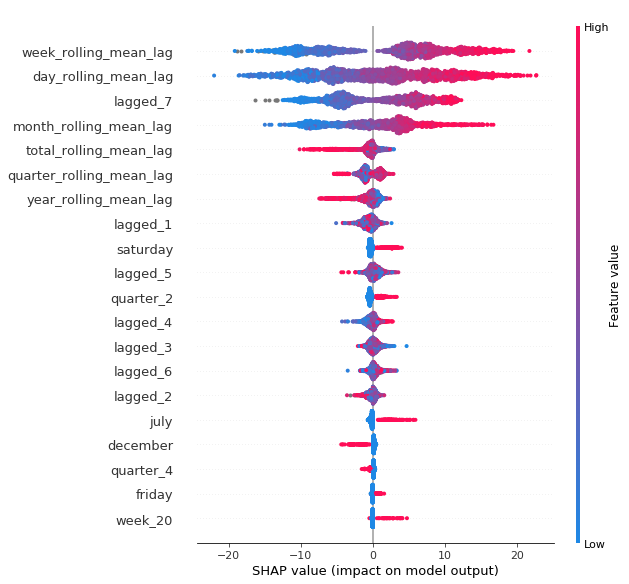

In [47]:
shap.summary_plot(shap_values_0815, set_0815_shap)